In [20]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX

from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima import auto_arima

In [2]:
df = pd.read_csv('./data.csv', parse_dates=True)
df.head()

date  Appliances  lights     T_out  Press_mm_hg  RH_out  \
0  1/11/2016 17:00          60      30  6.600000        733.5    92.0   
1  1/11/2016 17:10          60      30  6.483333        733.6    92.0   
2  1/11/2016 17:20          50      30  6.366667        733.7    92.0   
3  1/11/2016 17:30          50      40  6.250000        733.8    92.0   
4  1/11/2016 17:40          60      40  6.133333        733.9    92.0   

   Windspeed  Tdewpoint  Visibility  
0   7.000000        5.3   63.000000  
1   6.666667        5.2   59.166667  
2   6.333333        5.1   55.333333  
3   6.000000        5.0   51.500000  
4   5.666667        4.9   47.666667

In [3]:
df.date = pd.to_datetime(df.date)

In [4]:
df = df.set_index('date')

In [5]:
# resampling the data into hourly data
df = df.resample('1H').mean()

C:\Users\RAJESH\AppData\Local\Temp\ipykernel_8152\3934136706.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('1H').mean()


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3290 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Freq: h
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   3290 non-null   float64
 1   lights       3290 non-null   float64
 2   T_out        3290 non-null   float64
 3   Press_mm_hg  3290 non-null   float64
 4   RH_out       3290 non-null   float64
 5   Windspeed    3290 non-null   float64
 6   Tdewpoint    3290 non-null   float64
 7   Visibility   3290 non-null   float64
dtypes: float64(8)
memory usage: 231.3 KB


In [7]:
df.describe()

Appliances       lights        T_out  Press_mm_hg       RH_out  \
count  3290.000000  3290.000000  3290.000000  3290.000000  3290.000000   
mean     97.779129     3.803445     7.415410   755.522520    79.744656   
std      81.213695     6.900618     5.315858     7.398575    14.830042   
min      28.333333     0.000000    -4.961111   729.383333    25.250000   
25%      50.000000     0.000000     3.666667   750.916667    70.416667   
50%      63.333333     0.000000     6.916667   756.100000    83.666667   
75%     110.000000     3.333333    10.414583   760.931250    91.583333   
max     608.333333    51.666667    25.933333   772.258333   100.000000   

         Windspeed    Tdewpoint   Visibility  
count  3290.000000  3290.000000  3290.000000  
mean      4.039742     3.763098    38.327964  
std       2.430863     4.191967    11.212175  
min       0.416667    -6.475000     1.000000  
25%       2.000000     0.933333    31.833333  
50%       3.583333     3.412500    40.000000  
75%       5.416667     6.566667    40.000000  
max      13.000000    15.250000    66.000000

In [183]:
df.isnull().sum()

Appliances     0
lights         0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Tdewpoint      0
Visibility     0
dtype: int64

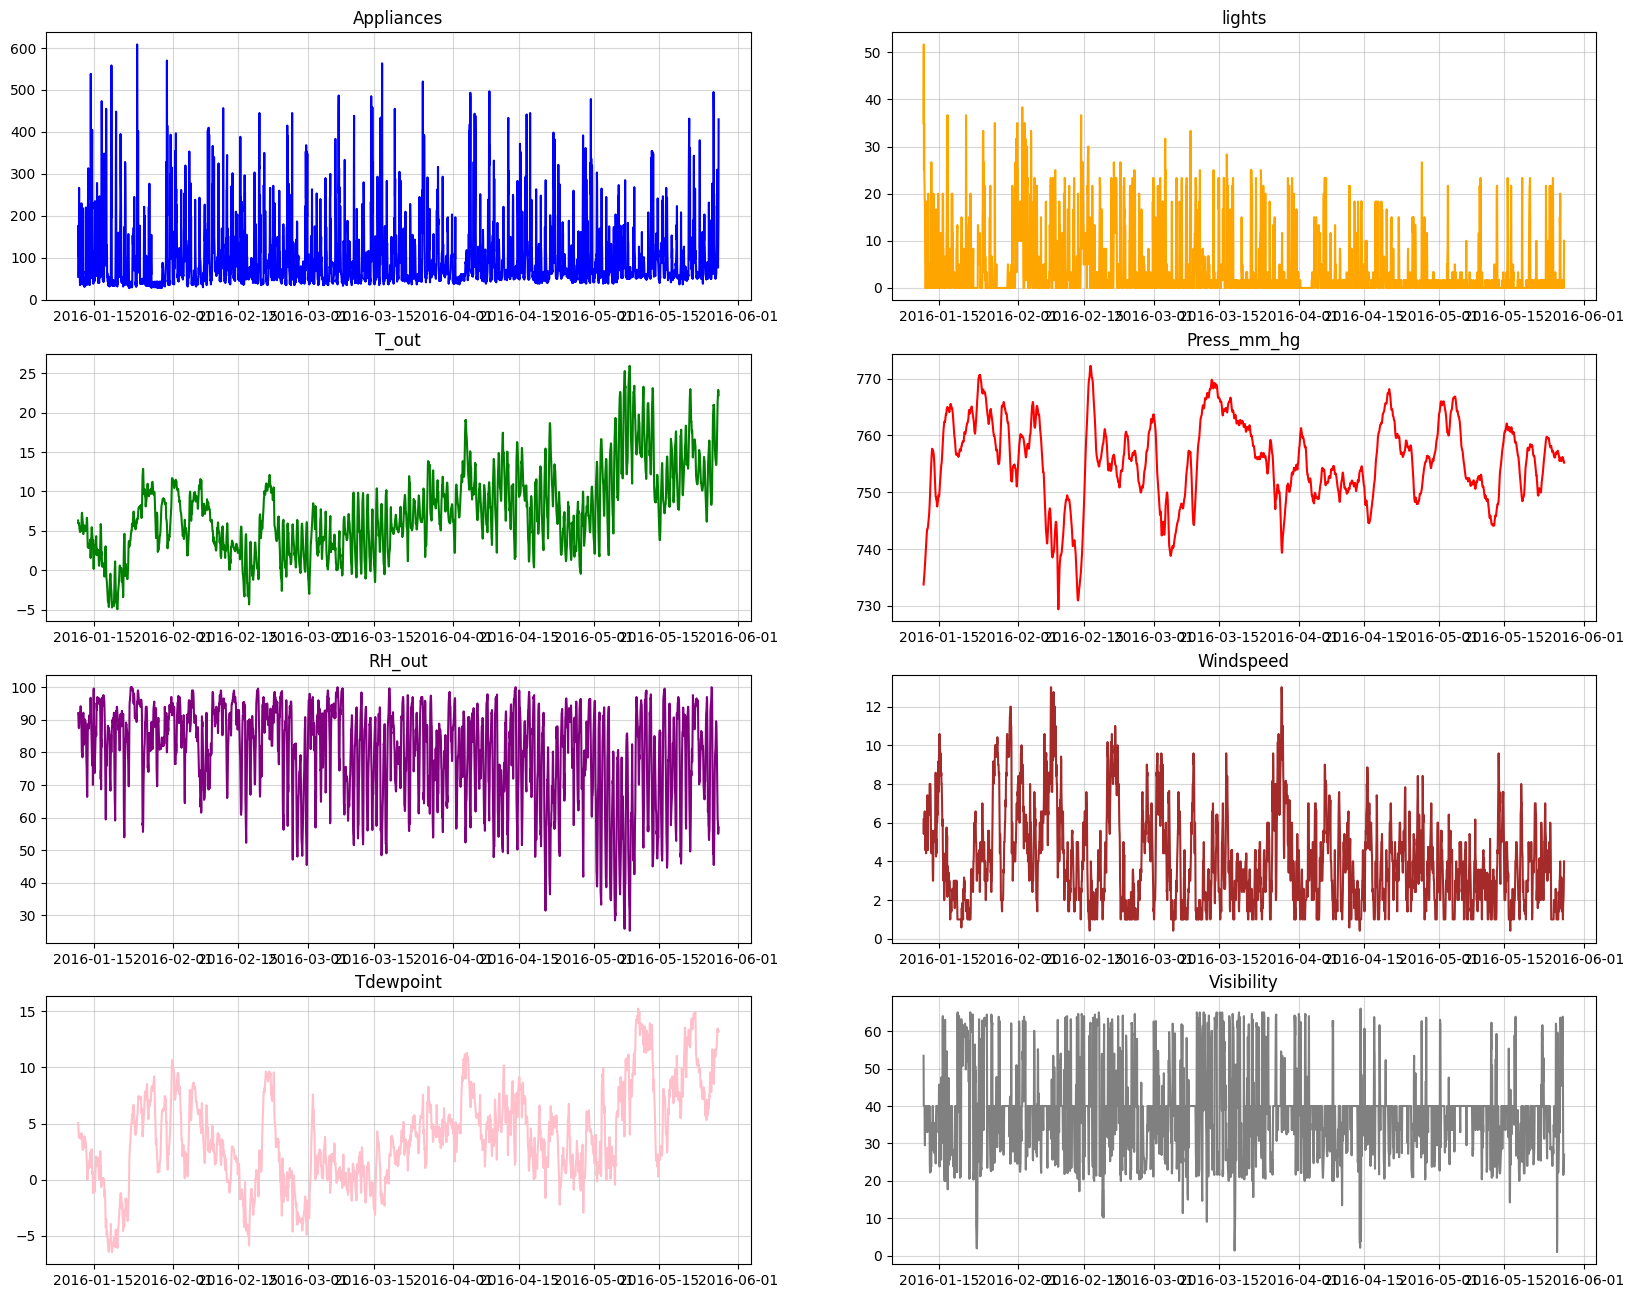

In [185]:
color_list = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

fig, ax = plt.subplots(nrows=4, ncols = 2, figsize = (20, 16))

for i in range(df.shape[1]):
    ax[i//2][i%2].plot(df.iloc[:,i], color = color_list[i])
    ax[i//2][i%2].grid(alpha = 0.5, which='both')
    ax[i//2][i%2].set_title(df.columns[i])

plt.show()

In [186]:
# checking for stationarity

for i in df.columns:
    result = adfuller(df[i])
    if result[1] < 0.05:
        print(f'{i} is stationary\np-value = {result[1]}\n')
    else:
        print(f'{i} is not stationary\np-value = {result[1]}\n')

Appliances is stationary
p-value = 8.833753129594426e-15

lights is stationary
p-value = 3.8726478913185725e-10

T_out is stationary
p-value = 0.01714989407309429

Press_mm_hg is stationary
p-value = 3.2776768852399884e-05

RH_out is stationary
p-value = 1.9945729428392366e-07

Windspeed is stationary
p-value = 7.207019560424297e-11

Tdewpoint is stationary
p-value = 0.0023241555195096975

Visibility is stationary
p-value = 2.8421843338661746e-28



all the features are stationary.

In [187]:
# getting optimal lags
model = VAR(df)
optimal_lags = model.select_order()
print('optimal lags = ', optimal_lags.selected_orders)
        

optimal lags =  {'aic': 23, 'bic': 4, 'hqic': 6, 'fpe': 23}


we will go with 4 lags

In [188]:
# checking for causation with respect to 'appliances' features

maxlag = 4
results = []

for i in df.columns:
    result = grangercausalitytests(df[['Appliances', i]], maxlag = maxlag)
    pvalues = [round(result[i+1][0]['ssr_ftest'][1],4) for i in range(maxlag)]    
    results.append(f'feature = {i}\tp-values = {pvalues}\n')




Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=3286, df_num=1
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=1
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=1
parameter F test:         F=1672.9749, p=0.0000  , df_denom=3286, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=3285, df_num=2
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=2
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=2
parameter F test:         F=928.2128, p=0.0000  , df_denom=3285, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=3283, df_num=3
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=3
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=3
parameter F test:         F=621.3618, p=0.0000  , df_denom=3283, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.0000  , p=1

In [189]:
for i in results:
    print(i,'\n')

feature = Appliances	p-values = [1.0, 1.0, 1.0, 1.0]
 

feature = lights	p-values = [0.1451, 0.0005, 0.0001, 0.0002]
 

feature = T_out	p-values = [0.002, 0.0001, 0.0001, 0.0]
 

feature = Press_mm_hg	p-values = [0.0985, 0.1956, 0.0351, 0.0016]
 

feature = RH_out	p-values = [0.0, 0.0004, 0.0004, 0.0]
 

feature = Windspeed	p-values = [0.0004, 0.0041, 0.0094, 0.0082]
 

feature = Tdewpoint	p-values = [0.4348, 0.4494, 0.5005, 0.3887]
 

feature = Visibility	p-values = [0.7071, 0.5372, 0.7338, 0.8265]
 



In [8]:
# from the above results, we can see that features 'lights', 'T_out', 'RH_out' are more correlated with 'Appliances' feature but in the video lecture, they have taken 'T_out' and 'Windspeed' features[lecture link : https://www.youtube.com/watch?v=TpQtD7ONfxQ&list=PL3N9eeOlCrP5cK0QRQxeJd6GrQvhAtpBK]. so we will do both in separate data frames

df_input1 = df[['Appliances', 'lights', 'T_out', 'RH_out']] #my selection
df_input2 = df[['Appliances', 'T_out', 'Windspeed']] #his selection

# splitting into train and test
df_input1_train = df_input1[:int(0.9*len(df_input1))]  #90% for train
df_input1_test = df_input1[int(0.9*len(df_input1)):]

df_input2_train = df_input2[:int(0.9*len(df_input1))]
df_input2_test = df_input2[int(0.9*len(df_input1)):]


In [191]:
df_input1_train.shape, df_input1_test.shape, df_input2_train.shape, df_input2_test.shape

((2961, 4), (329, 4), (2961, 3), (329, 3))

In [192]:
# var model
# each feature in the model is a linear function of the past lags of itself and past lags of other variables

# before that we will get the best lag values
model = VAR(df_input2_train, freq = '1H') # setting frequency as 1 hour as we have hourly data

model.select_order(50).summary()

c:\Users\RAJESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:595: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = to_offset(freq)


<class 'statsmodels.iolib.table.SimpleTable'>

the BIC is lowest at lag 7 so we will use lag 7. for AIC, lowest lag is 26

In [193]:
# training VAR() with df_input2_train data
model2 = VAR(df_input2_train, freq='1H')
result2 = model.fit(maxlags = 7)

In [194]:
result2.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 29, Apr, 2024
Time:                     08:09:16
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    5.98610
Nobs:                     2954.00    HQIC:                   5.90043
Log likelihood:          -21152.4    FPE:                    348.017
AIC:                      5.85225    Det(Omega_mle):         340.356
--------------------------------------------------------------------
Results for equation Appliances
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                37.865935         3.448219           10.981           0.000
L1.Appliances         0.451436         0.018470           24.442           0.000
L1.T_out              2.328238         2.534185        

In [195]:
# best lag value for df_input2_train
result2.k_ar

7

In [196]:
# optimal lag for df_input1_train data
model = VAR(df_input1_train, freq='1H')
model.select_order(50).summary()

c:\Users\RAJESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:595: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = to_offset(freq)


<class 'statsmodels.iolib.table.SimpleTable'>

lowest lag for BIC for this data is 6

In [197]:
# training VAR() with df_input1_train data
model1 = VAR(df_input1_train, freq = '1H')
result1 = model1.fit(maxlags = 6)

In [198]:
result1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 29, Apr, 2024
Time:                     08:09:27
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    11.5491
Nobs:                     2955.00    HQIC:                   11.4194
Log likelihood:          -33436.1    FPE:                    84658.9
AIC:                      11.3464    Det(Omega_mle):         81853.5
--------------------------------------------------------------------
Results for equation Appliances
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                25.735808        11.258919            2.286           0.022
L1.Appliances         0.438223         0.018783           23.330           0.000
L1.lights             0.743278         0.254109        

In [199]:
# best lag for df_input1_train
result1.k_ar

6

In [200]:
# forecasting df_input2 for next 329 hours
lag_2 = result2.k_ar

forecast2 = result2.forecast(df_input2_train.values[-lag_2:], steps=329)  

In [201]:
# forecasting fro df_input1 for next 329 hours
lag_1 = result1.k_ar
forecast1 = result1.forecast(df_input1_train.values[-lag_1:], steps = 329)

In [202]:
forecast1 = pd.DataFrame(forecast1, columns = df_input1.columns)
forecast2 = pd.DataFrame(forecast2, columns = df_input2.columns)

In [203]:
forecast1.head()

Appliances    lights     T_out     RH_out
0   47.919300 -0.725844  8.850977  85.680623
1   56.273559 -0.612200  8.511154  86.934939
2   63.275695 -0.029856  8.346939  87.107117
3   73.778712  0.854224  8.294571  86.746980
4   85.209279  1.762856  8.373280  86.060711

In [204]:
forecast2.head()

Appliances     T_out  Windspeed
0   44.345980  8.926516   3.993332
1   33.709232  8.817198   4.138710
2   38.323442  9.019533   4.188856
3   53.397569  9.335619   4.314291
4   60.937989  9.569742   4.400938

plotting the predictions of df_input2

In [205]:
temp1 = df_input2_train.reset_index()
temp2 = df_input2_test.reset_index()
temp2 = pd.DataFrame(temp2.values, columns = temp2.columns, index = range(temp1.shape[0],temp1.shape[0] + df_input2_test.shape[0]))
temp3 = forecast2.set_index(temp2.index)

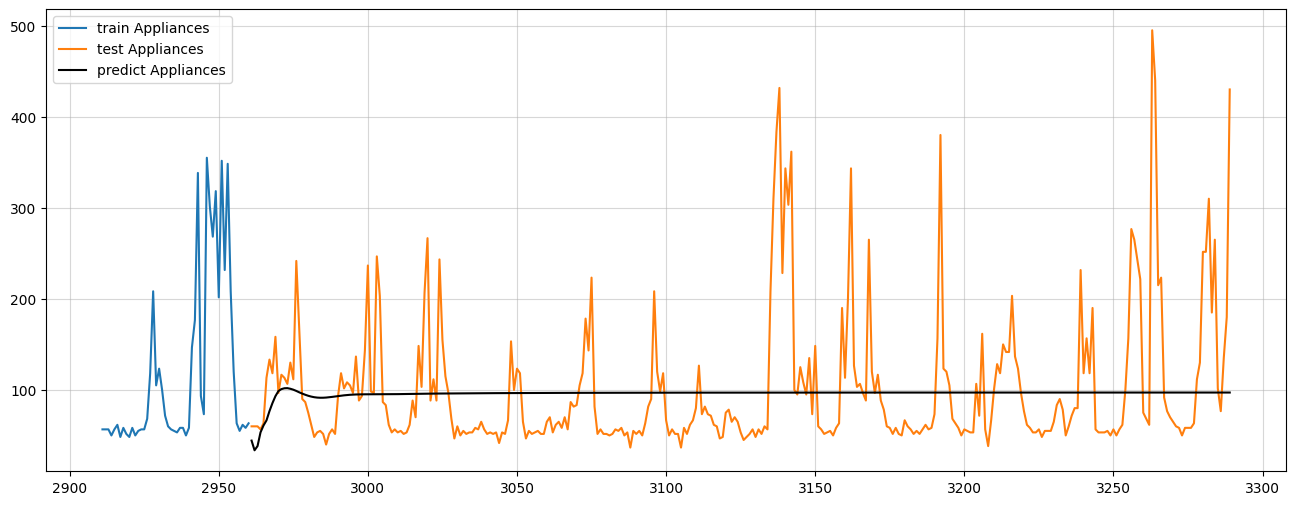

In [206]:

# appliances feature
plt.subplots(figsize = (16, 6))

plt.plot(temp1['Appliances'].tail(50), label = 'train Appliances')
plt.plot(temp2['Appliances'],label = 'test Appliances' )
plt.plot(temp3['Appliances'],label = 'predict Appliances', color = 'black')

plt.grid(alpha=0.5, which = 'both')
plt.legend()
plt.show()

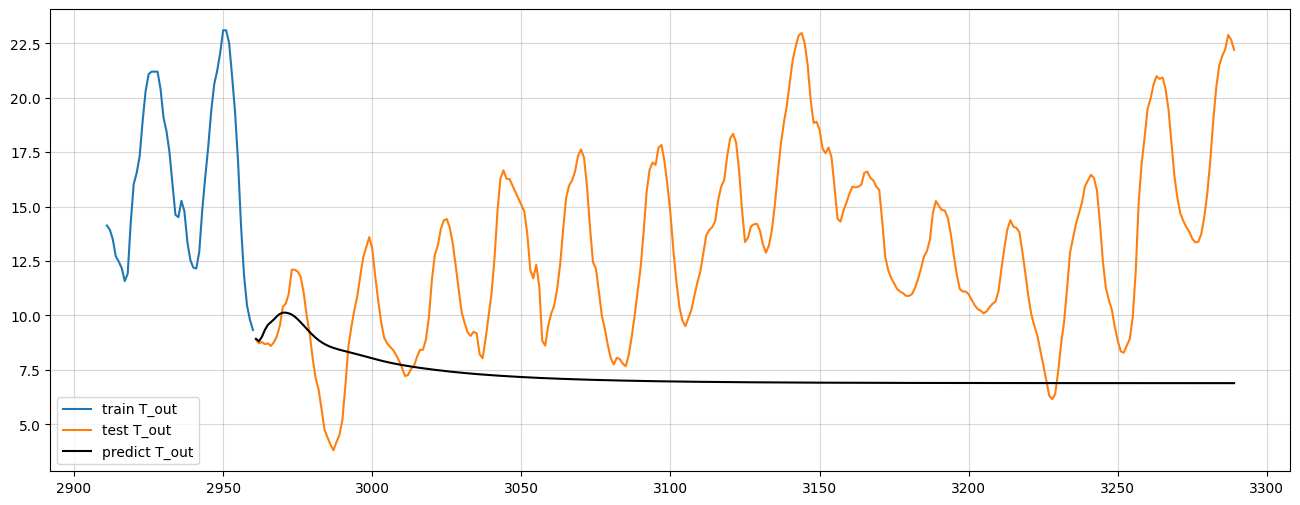

In [207]:
# T_out feature
plt.subplots(figsize = (16, 6))

plt.plot(temp1['T_out'].tail(50), label = 'train T_out')
plt.plot(temp2['T_out'],label = 'test T_out' )
plt.plot(temp3['T_out'],label = 'predict T_out', color = 'black')

plt.grid(alpha=0.5, which = 'both')
plt.legend()
plt.show()

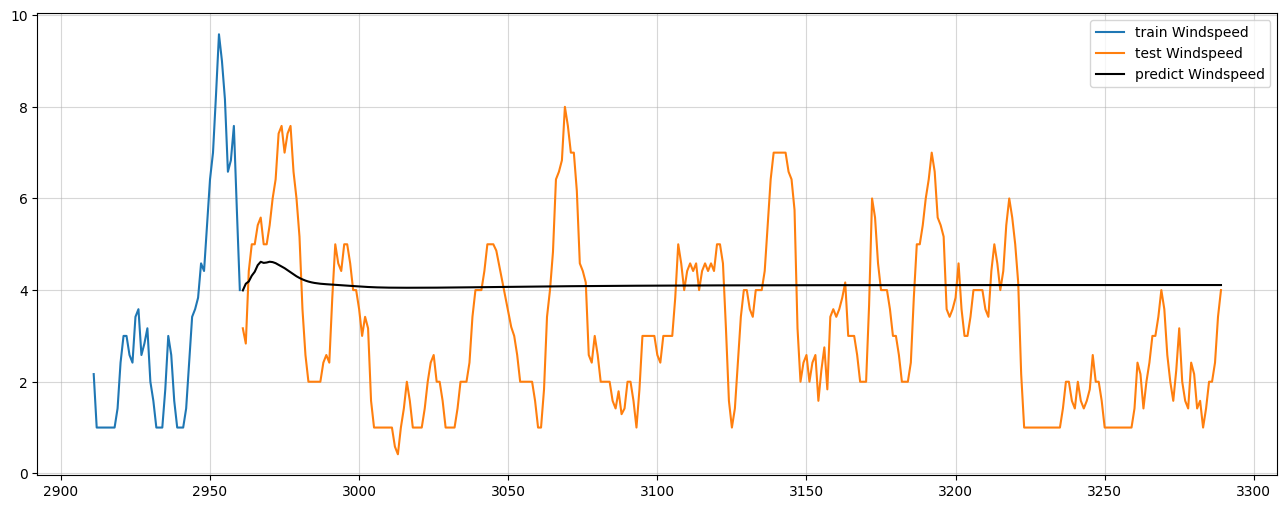

In [208]:
# Windspeed feature
plt.subplots(figsize = (16, 6))

plt.plot(temp1['Windspeed'].tail(50), label = 'train Windspeed')
plt.plot(temp2['Windspeed'],label = 'test Windspeed' )
plt.plot(temp3['Windspeed'],label = 'predict Windspeed', color = 'black')

plt.grid(alpha=0.5, which = 'both')
plt.legend()
plt.show()

plotting the predictions of df_input1 data

In [209]:
df_input1

Appliances     lights      T_out     RH_out
date                                                            
2016-01-11 17:00:00   55.000000  35.000000   6.308333  92.000000
2016-01-11 18:00:00  176.666667  51.666667   5.941667  91.583333
2016-01-11 19:00:00  173.333333  25.000000   6.000000  89.750000
2016-01-11 20:00:00  125.000000  35.000000   6.000000  87.583333
2016-01-11 21:00:00  103.333333  23.333333   5.833333  87.416667
...                         ...        ...        ...        ...
2016-05-27 14:00:00  101.666667   1.666667  21.916667  59.000000
2016-05-27 15:00:00   76.666667   0.000000  22.216667  57.333333
2016-05-27 16:00:00  135.000000   0.000000  22.883333  55.000000
2016-05-27 17:00:00  180.000000   3.333333  22.666667  55.833333
2016-05-27 18:00:00  430.000000  10.000000  22.200000  57.000000

[3290 rows x 4 columns]

In [210]:
temp1 = df_input1_train.reset_index()
temp2 = df_input1_test.reset_index()
temp2 = pd.DataFrame(temp2.values, columns = temp2.columns, index = range(temp1.shape[0],temp1.shape[0] + df_input2_test.shape[0]))
temp3 = forecast1.set_index(temp2.index)

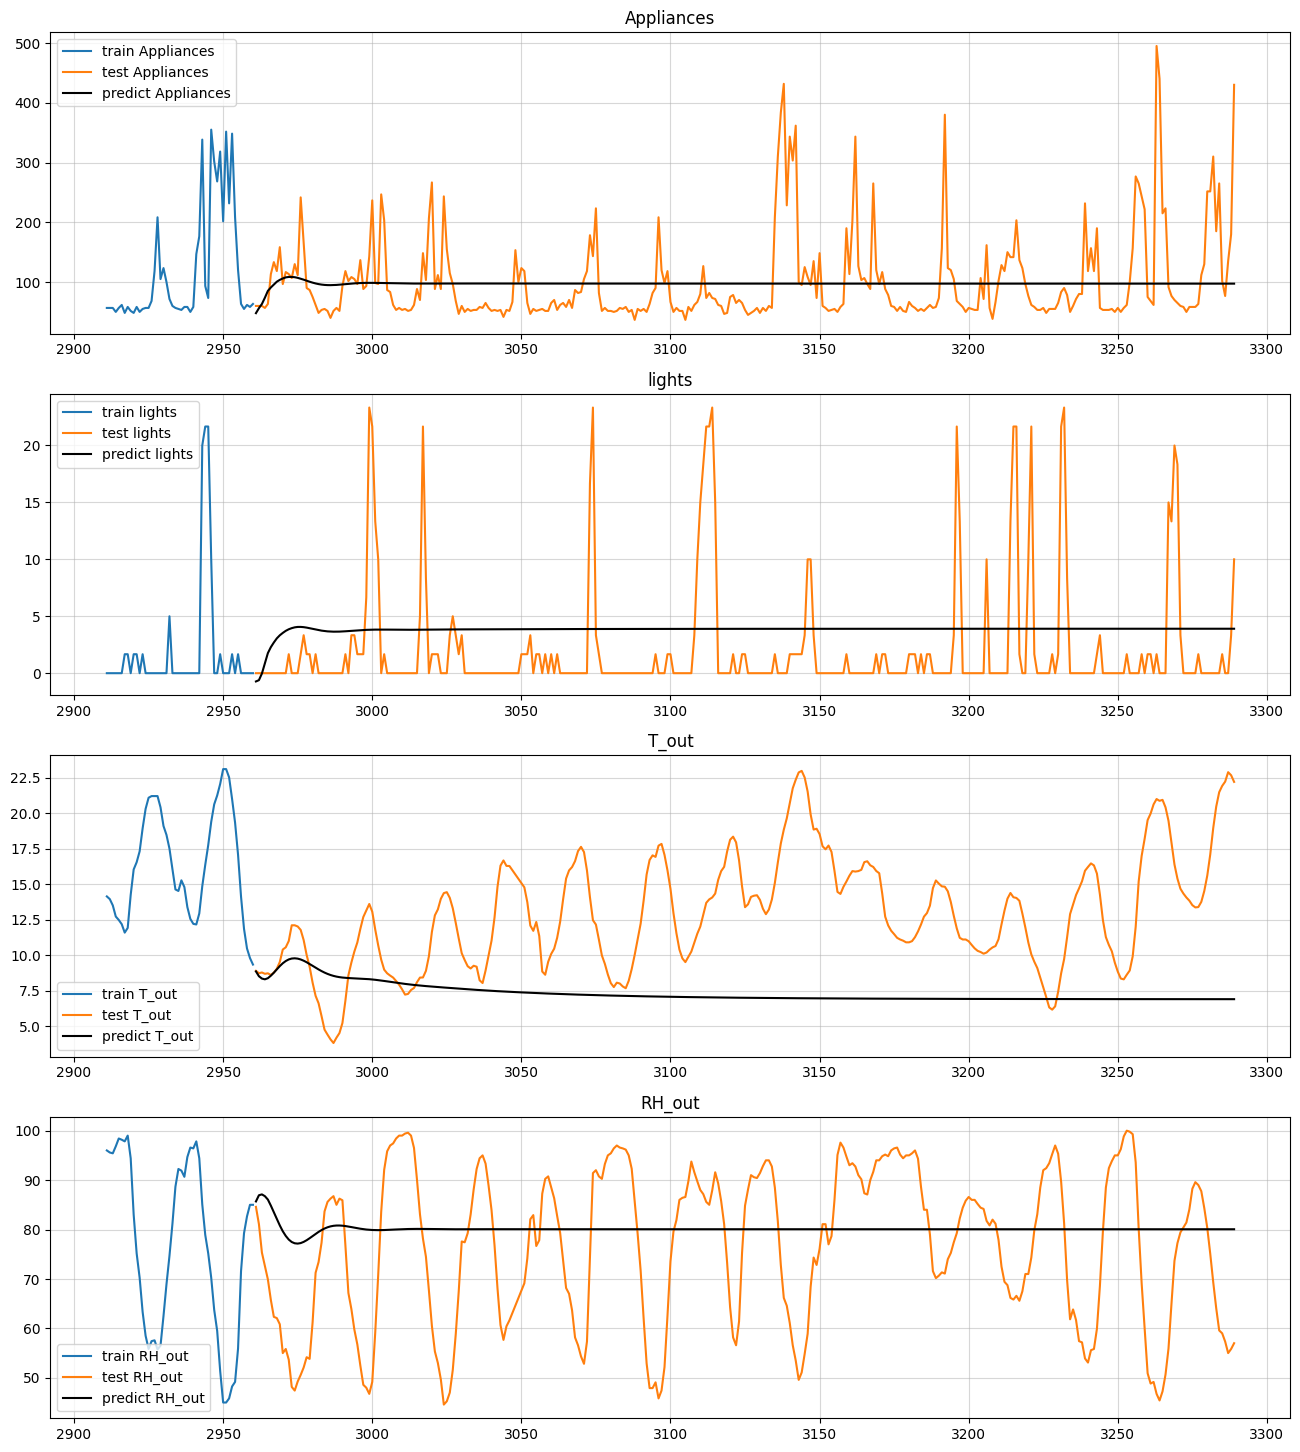

In [211]:
fig, ax = plt.subplots(nrows = 4, ncols = 1, figsize = (16, 18))


# Appliances feature
ax[0].plot(temp1['Appliances'].tail(50), label = 'train Appliances')
ax[0].plot(temp2['Appliances'],label = 'test Appliances' )
ax[0].plot(temp3['Appliances'],label = 'predict Appliances', color = 'black')
ax[0].set_title('Appliances')
ax[0].grid(alpha=0.5, which = 'both')
ax[0].legend()

# lights feature
ax[1].plot(temp1['lights'].tail(50), label = 'train lights')
ax[1].plot(temp2['lights'],label = 'test lights' )
ax[1].plot(temp3['lights'],label = 'predict lights', color = 'black')
ax[1].set_title('lights')
ax[1].grid(alpha=0.5, which = 'both')
ax[1].legend()

# T_out feature
ax[2].plot(temp1['T_out'].tail(50), label = 'train T_out')
ax[2].plot(temp2['T_out'],label = 'test T_out' )
ax[2].plot(temp3['T_out'],label = 'predict T_out', color = 'black')
ax[2].set_title('T_out')
ax[2].grid(alpha=0.5, which = 'both')
ax[2].legend()

# RH_out feature
ax[3].plot(temp1['RH_out'].tail(50), label = 'train RH_out')
ax[3].plot(temp2['RH_out'],label = 'test RH_out' )
ax[3].plot(temp3['RH_out'],label = 'predict RH_out', color = 'black')
ax[3].set_title('RH_out')
ax[3].grid(alpha=0.5, which = 'both')
ax[3].legend()


plt.grid(alpha=0.5, which = 'both')
plt.legend()
plt.show()

the results are horrible so we wil try to more smoothen the data

In [10]:
df_input1_train_roll = df_input1_train.resample('1D').mean()
df_input1_test_roll = df_input1_test.resample('1D').mean()

df_input2_train_roll = df_input2_train.resample('1D').mean()
df_input2_test_roll = df_input2_test.resample('1D').mean()

<AxesSubplot: xlabel='date'>

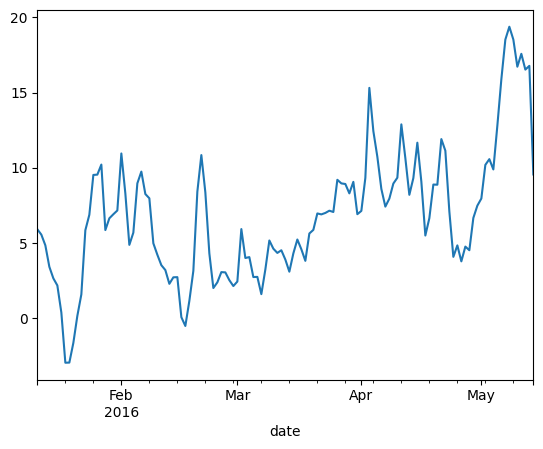

In [214]:
df_input1_train_roll.T_out.plot()

In [215]:
# training the model with new data

model = VAR(df_input1_train_roll, freq = '1D')
model.select_order(20).summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [216]:
model = VAR(df_input1_train_roll, freq = '1D')
result1 = model.fit(maxlags=1)

In [217]:
result1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 29, Apr, 2024
Time:                     08:09:38
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    14.5098
Nobs:                     124.000    HQIC:                   14.2397
Log likelihood:          -1555.20    FPE:                1.27070e+06
AIC:                      14.0549    Det(Omega_mle):     1.08485e+06
--------------------------------------------------------------------
Results for equation Appliances
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                68.444790        32.339361            2.116           0.034
L1.Appliances         0.089469         0.095977            0.932           0.351
L1.lights            -0.295170         0.783836        

In [218]:
df_input1_test_roll

Appliances    lights      T_out     RH_out
date                                                  
2016-05-14  103.106061  0.530303   9.622348  61.837121
2016-05-15  104.027778  3.750000   8.556597  72.690972
2016-05-16  100.138889  2.361111  10.286806  74.694444
2016-05-17   66.041667  0.347222  12.494792  76.281250
2016-05-18   82.222222  2.222222  12.923611  76.802083
2016-05-19   70.000000  0.208333  12.264583  74.989583
2016-05-20   64.722222  5.555556  13.777431  81.961806
2016-05-21  161.666667  1.527778  17.851042  74.500000
2016-05-22  110.138889  0.277778  15.513889  90.545139
2016-05-23   83.055556  2.013889  12.570486  84.225694
2016-05-24   96.180556  4.236111  11.568750  76.680556
2016-05-25   83.888889  2.569444  11.563542  74.774306
2016-05-26  147.013889  3.125000  14.923611  74.336806
2016-05-27  149.210526  1.052632  17.414912  73.517544

In [11]:
lag1 = result1.k_ar

forecast1 = result1.forecast(df_input1_train_roll[-lag1:].values, steps=14)

NameError: name 'result1' is not defined

In [221]:
forecast1 = pd.DataFrame(forecast1, columns = df_input1_train_roll.columns)

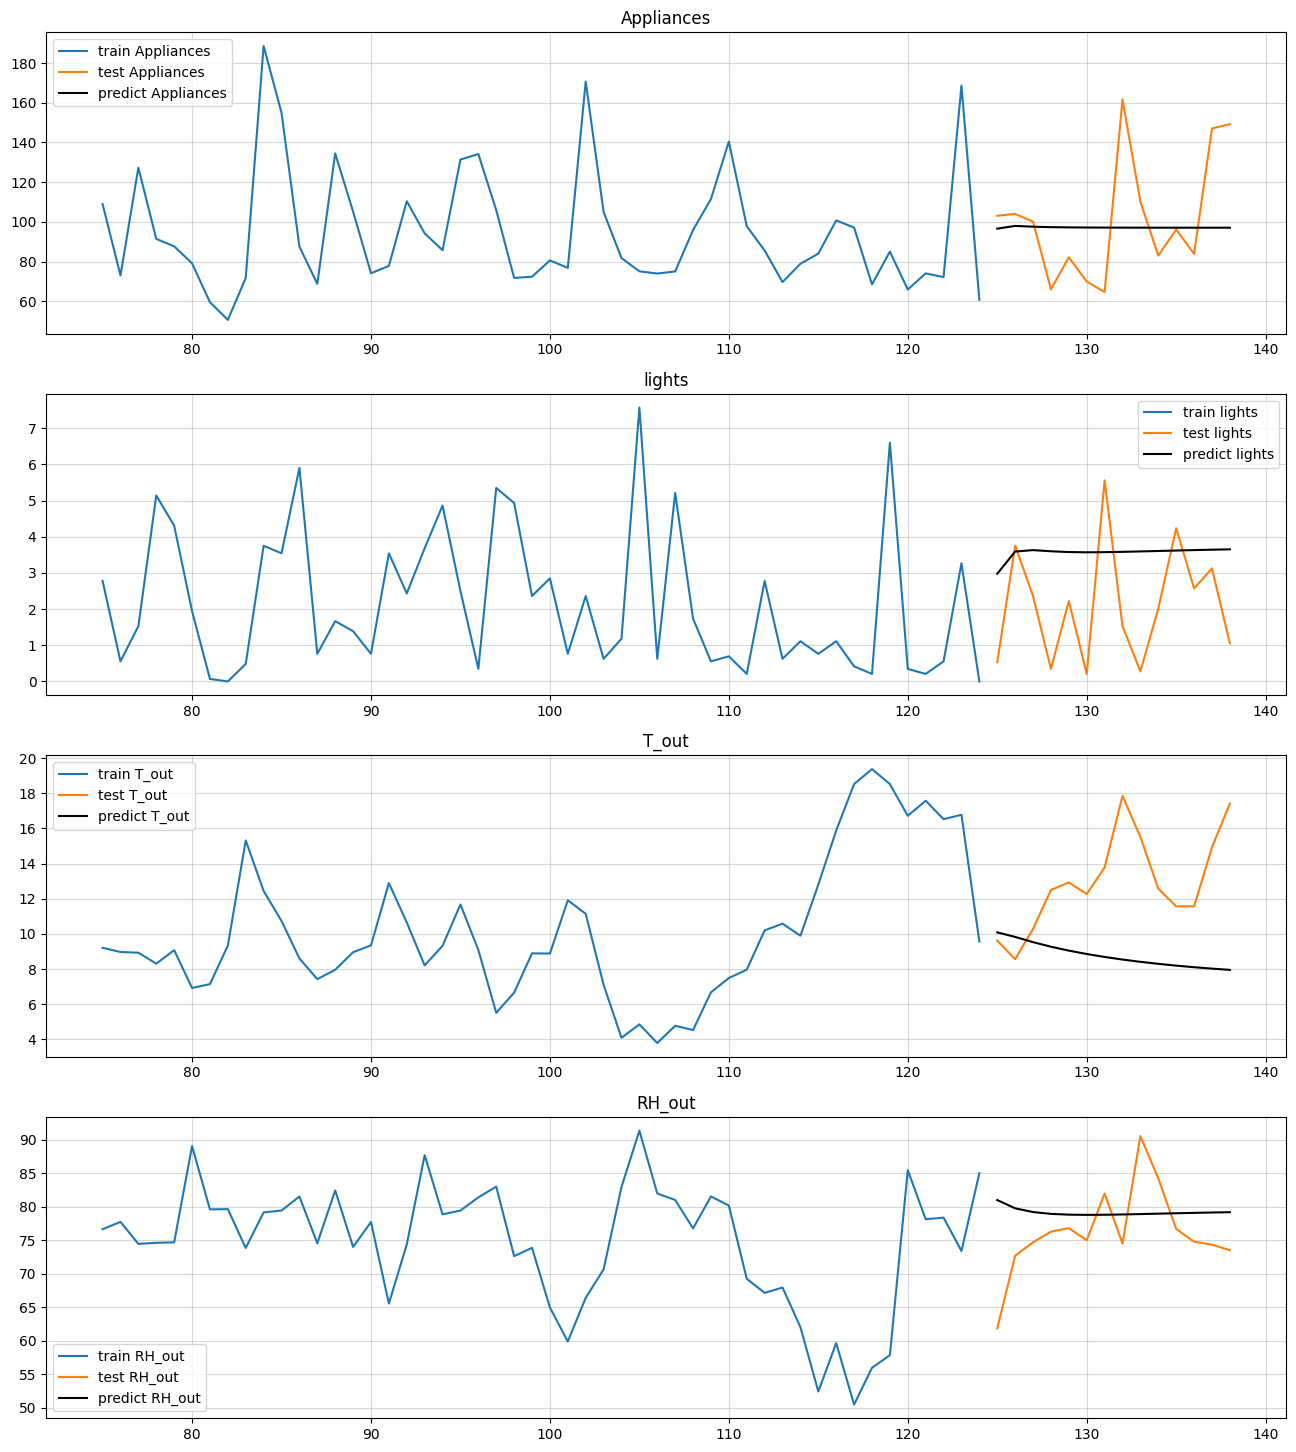

In [222]:
# visualising the predictions

temp1 = df_input1_train_roll.reset_index()
temp2 = df_input1_test_roll.reset_index()
temp2 = pd.DataFrame(temp2.values, columns = temp2.columns, index = range(temp1.shape[0],temp1.shape[0] + df_input1_test_roll.shape[0]))
temp3 = forecast1.set_index(temp2.index)

fig, ax = plt.subplots(nrows = 4, ncols = 1, figsize = (16, 18))

# Appliances feature
ax[0].plot(temp1['Appliances'].tail(50), label = 'train Appliances')
ax[0].plot(temp2['Appliances'],label = 'test Appliances' )
ax[0].plot(temp3['Appliances'],label = 'predict Appliances', color = 'black')
ax[0].set_title('Appliances')
ax[0].grid(alpha=0.5, which = 'both')
ax[0].legend()

# lights feature
ax[1].plot(temp1['lights'].tail(50), label = 'train lights')
ax[1].plot(temp2['lights'],label = 'test lights' )
ax[1].plot(temp3['lights'],label = 'predict lights', color = 'black')
ax[1].set_title('lights')
ax[1].grid(alpha=0.5, which = 'both')
ax[1].legend()

# T_out feature
ax[2].plot(temp1['T_out'].tail(50), label = 'train T_out')
ax[2].plot(temp2['T_out'],label = 'test T_out' )
ax[2].plot(temp3['T_out'],label = 'predict T_out', color = 'black')
ax[2].set_title('T_out')
ax[2].grid(alpha=0.5, which = 'both')
ax[2].legend()

# RH_out feature
ax[3].plot(temp1['RH_out'].tail(50), label = 'train RH_out')
ax[3].plot(temp2['RH_out'],label = 'test RH_out' )
ax[3].plot(temp3['RH_out'],label = 'predict RH_out', color = 'black')
ax[3].set_title('RH_out')
ax[3].grid(alpha=0.5, which = 'both')
ax[3].legend()

plt.show()

In [223]:
# training for input2

model = VAR(df_input2_train_roll, freq = '1D')
model.select_order(20).summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [224]:
model = VAR(df_input2_train_roll, freq = '1D')
result2 = model.fit(maxlags = 1)

In [225]:
result2.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 29, Apr, 2024
Time:                     08:09:44
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    9.39105
Nobs:                     124.000    HQIC:                   9.22899
Log likelihood:          -1081.17    FPE:                    9119.68
AIC:                      9.11812    Det(Omega_mle):         8291.14
--------------------------------------------------------------------
Results for equation Appliances
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                83.419439        11.035739            7.559           0.000
L1.Appliances         0.062414         0.091046            0.686           0.493
L1.T_out             -0.208653         0.634704        

In [226]:
# forecasting 
lag2 = result2.k_ar
forecast2 = result2.forecast(df_input2_train_roll[-lag2:].values, steps = df_input2_test_roll.shape[0])

In [227]:
forecast2 = pd.DataFrame(forecast2, columns = df_input2_train_roll.columns)

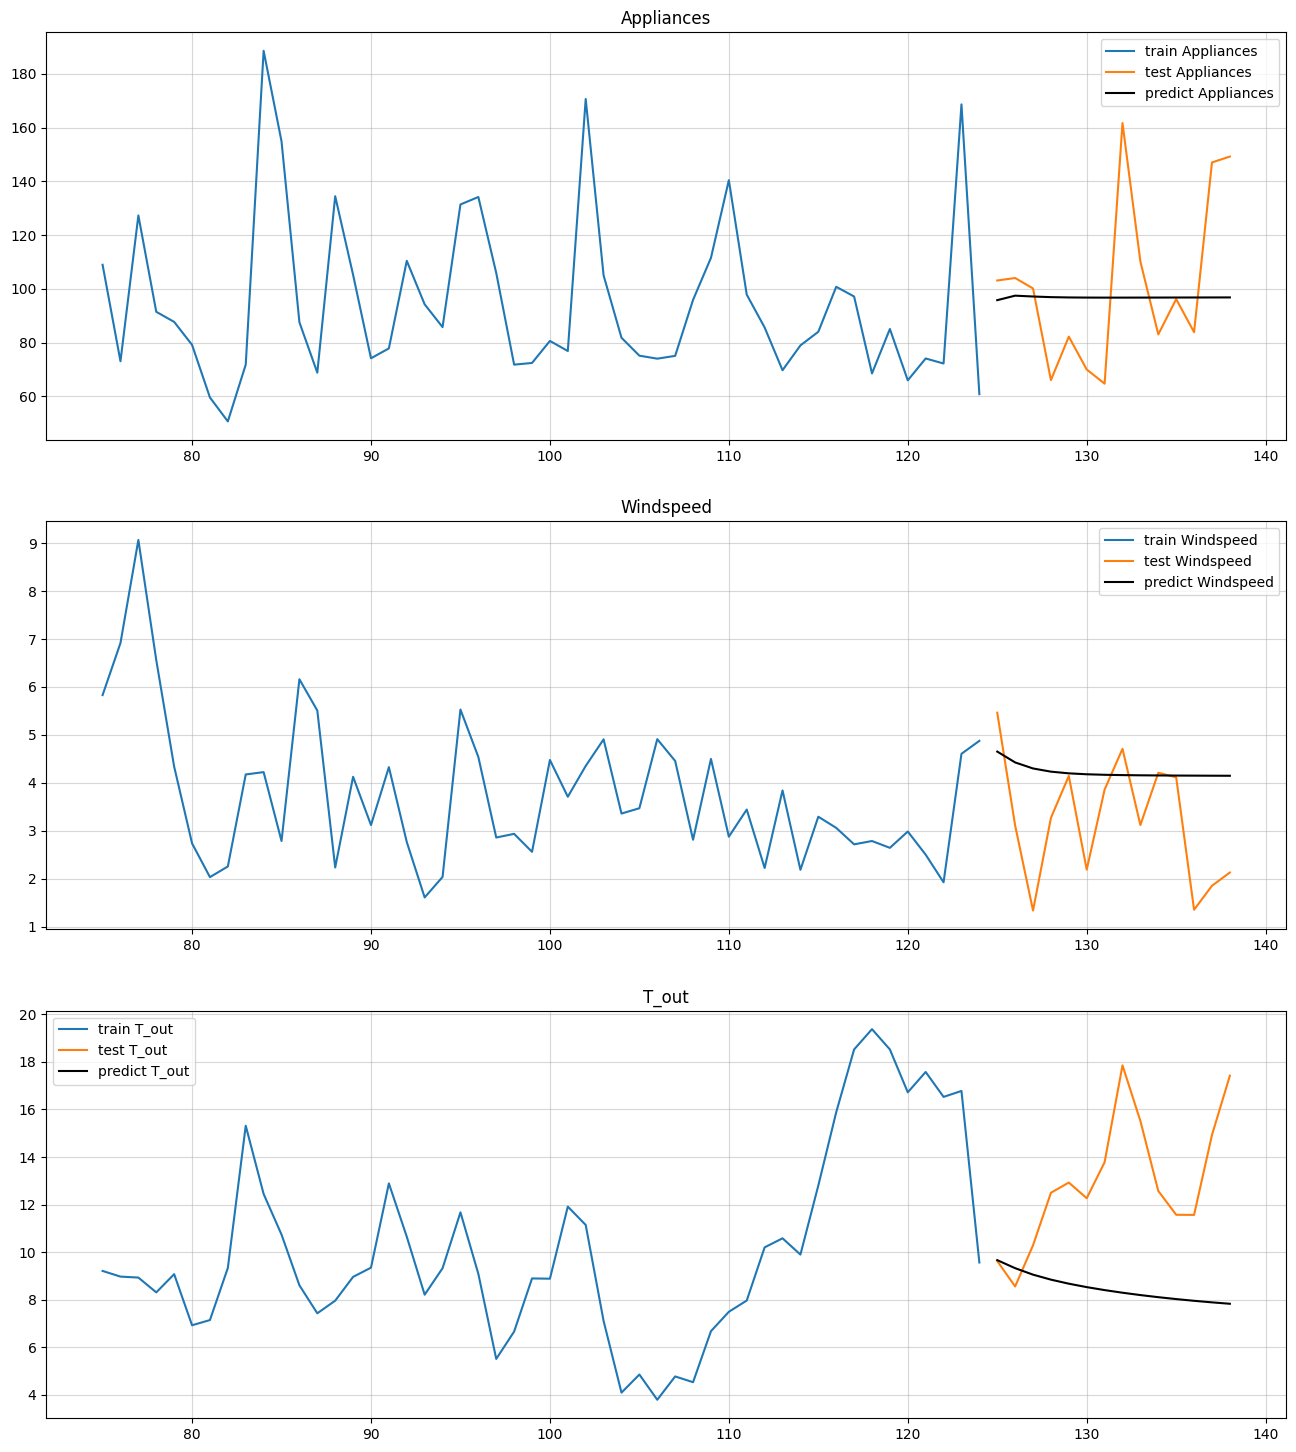

In [228]:
# visualising the predictions

temp1 = df_input2_train_roll.reset_index()
temp2 = df_input2_test_roll.reset_index()
temp2 = pd.DataFrame(temp2.values, columns = temp2.columns, index = range(temp1.shape[0],temp1.shape[0] + df_input2_test_roll.shape[0]))
temp3 = forecast2.set_index(temp2.index)

fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (16, 18))

# Appliances feature
ax[0].plot(temp1['Appliances'].tail(50), label = 'train Appliances')
ax[0].plot(temp2['Appliances'],label = 'test Appliances' )
ax[0].plot(temp3['Appliances'],label = 'predict Appliances', color = 'black')
ax[0].set_title('Appliances')
ax[0].grid(alpha=0.5, which = 'both')
ax[0].legend()

# Windspeed feature
ax[1].plot(temp1['Windspeed'].tail(50), label = 'train Windspeed')
ax[1].plot(temp2['Windspeed'],label = 'test Windspeed' )
ax[1].plot(temp3['Windspeed'],label = 'predict Windspeed', color = 'black')
ax[1].set_title('Windspeed')
ax[1].grid(alpha=0.5, which = 'both')
ax[1].legend()

# T_out feature
ax[2].plot(temp1['T_out'].tail(50), label = 'train T_out')
ax[2].plot(temp2['T_out'],label = 'test T_out' )
ax[2].plot(temp3['T_out'],label = 'predict T_out', color = 'black')
ax[2].set_title('T_out')
ax[2].grid(alpha=0.5, which = 'both')
ax[2].legend()

plt.show()

In [231]:
# lets try VARMAX model on df_input1_train_roll
lag1 = result1.k_ar
model = VARMAX(endog=df_input1_train_roll, exog = None, order = (lag1, 0))
result1 = model.fit(maxiter = 100)
result1.summary()

c:\Users\RAJESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")


c:\Users\RAJESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        Statespace Model Results                                       
=======================================================================================================
Dep. Variable:     ['Appliances', 'lights', 'T_out', 'RH_out']   No. Observations:                  125
Model:                                                  VAR(1)   Log Likelihood               -1595.789
                                                   + intercept   AIC                           3251.579
Date:                                         Mon, 29 Apr 2024   BIC                           3336.428
Time:                                                 08:17:08   HQIC                          3286.049
Sample:                                             01-11-2016                                         
                                                  - 05-14-2016                                         
Covariance Type:                                           opg                                         
==============================================================================================
Ljung-Box (L1) (Q):     0.00, 2.21, 5.17, 0.06   Jarque-Bera (JB):   18.45, 805.21, 2.85, 5.36
Prob(Q):                1.00, 0.14, 0.02, 0.81   Prob(JB):              0.00, 0.00, 0.24, 0.07
Heteroskedasticity (H): 1.07, 0.28, 1.10, 1.07   Skew:                  0.91, 2.20, 0.24, 0.44
Prob(H) (two-sided):    0.83, 0.00, 0.77, 0.82   Kurtosis:             3.50, 14.63, 3.57, 3.51
                         Results for equation Appliances                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept        68.7379     34.707      1.981      0.048       0.714     136.762
L1.Appliances     0.0909      0.128      0.707      0.479      -0.161       0.343
L1.lights        -0.0433      1.446     -0.030      0.976      -2.878       2.791
L1.T_out          0.1293      0.739      0.175      0.861      -1.319       1.578
L1.RH_out         0.2462      0.415      0.593      0.553      -0.568       1.060
                           Results for equation lights                           
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept        -4.5522      5.715     -0.797      0.426     -15.754       6.649
L1.Appliances     0.0134      0.019      0.709      0.478      -0.024       0.050
L1.lights         0.3115      0.092      3.383      0.001       0.131       0.492
L1.T_out         -0.0580      0.127     -0.455      0.649      -0.308       0.192
L1.RH_out         0.0816      0.068      1.204      0.228      -0.051       0.214
                            Results for equation T_out                           
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         2.3690      2.154      1.100      0.271      -1.853       6.591
L1.Appliances    -0.0127      0.006     -2.262      0.024      -0.024      -0.002
L1.lights        -0.0733      0.065     -1.131      0.258      -0.200       0.054
L1.T_out          0.8727      0.051     16.978      0.000       0.772       0.973
L1.RH_out         0.0008      0.024      0.033      0.973      -0.046       0.048
                           Results for equation RH_out                           
=================================================================================
                    coef    std err          z      P>|z|  

In [248]:
# forecasting the predictions 
forecast1 = result1.forecast(steps=14)

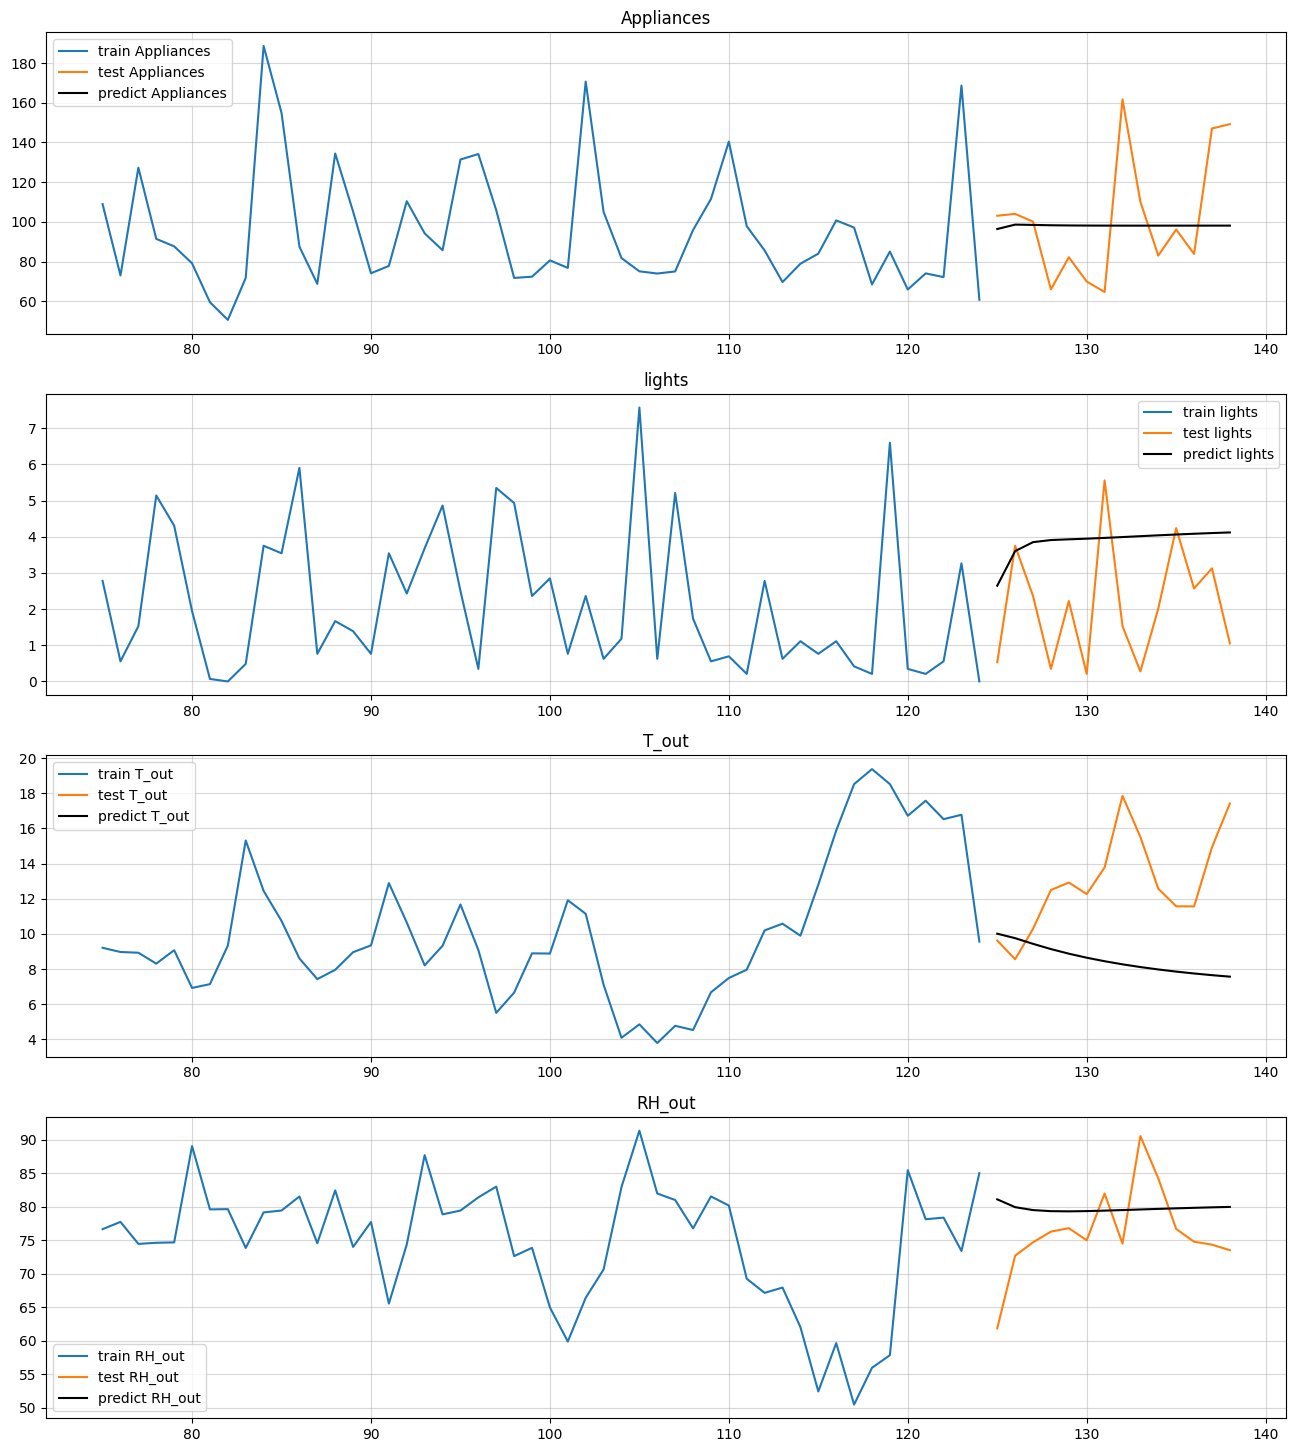

In [253]:
# visualising the predictions

temp1 = df_input1_train_roll.reset_index()
temp2 = df_input1_test_roll.reset_index()
temp2 = pd.DataFrame(temp2.values, columns = temp2.columns, index = range(temp1.shape[0],temp1.shape[0] + df_input1_test_roll.shape[0]))
temp3 = forecast1.set_index(temp2.index)

fig, ax = plt.subplots(nrows = 4, ncols = 1, figsize = (16, 18))

# Appliances feature
ax[0].plot(temp1['Appliances'].tail(50), label = 'train Appliances')
ax[0].plot(temp2['Appliances'],label = 'test Appliances' )
ax[0].plot(temp3['Appliances'],label = 'predict Appliances', color = 'black')
ax[0].set_title('Appliances')
ax[0].grid(alpha=0.5, which = 'both')
ax[0].legend()

# lights feature
ax[1].plot(temp1['lights'].tail(50), label = 'train lights')
ax[1].plot(temp2['lights'],label = 'test lights' )
ax[1].plot(temp3['lights'],label = 'predict lights', color = 'black')
ax[1].set_title('lights')
ax[1].grid(alpha=0.5, which = 'both')
ax[1].legend()

# T_out feature
ax[2].plot(temp1['T_out'].tail(50), label = 'train T_out')
ax[2].plot(temp2['T_out'],label = 'test T_out' )
ax[2].plot(temp3['T_out'],label = 'predict T_out', color = 'black')
ax[2].set_title('T_out')
ax[2].grid(alpha=0.5, which = 'both')
ax[2].legend()

# RH_out feature
ax[3].plot(temp1['RH_out'].tail(50), label = 'train RH_out')
ax[3].plot(temp2['RH_out'],label = 'test RH_out' )
ax[3].plot(temp3['RH_out'],label = 'predict RH_out', color = 'black')
ax[3].set_title('RH_out')
ax[3].grid(alpha=0.5, which = 'both')
ax[3].legend()

plt.show()

In [232]:
# lets try VARMAX model on df_input2_train_roll
lag2 = result2.k_ar
model = VARMAX(endog=df_input2_train_roll, exog = None, order = (lag2, 0))
result2 = model.fit(maxiter = 100)
result2.summary()

c:\Users\RAJESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")
c:\Users\RAJESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    Statespace Model Results                                    
================================================================================================
Dep. Variable:     ['Appliances', 'T_out', 'Windspeed']   No. Observations:                  125
Model:                                           VAR(1)   Log Likelihood               -1090.691
                                            + intercept   AIC                           2217.383
Date:                                  Mon, 29 Apr 2024   BIC                           2268.292
Time:                                          08:18:23   HQIC                          2238.065
Sample:                                      01-11-2016                                         
                                           - 05-14-2016                                         
Covariance Type:                                    opg                                         
===================================================================================
Ljung-Box (L1) (Q):       0.01, 6.79, 0.40   Jarque-Bera (JB):    18.87, 3.86, 7.12
Prob(Q):                  0.94, 0.01, 0.53   Prob(JB):             0.00, 0.15, 0.03
Heteroskedasticity (H):   1.09, 1.04, 0.55   Skew:                 0.89, 0.32, 0.58
Prob(H) (two-sided):      0.79, 0.89, 0.06   Kurtosis:             3.68, 3.57, 3.09
                         Results for equation Appliances                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept        83.7431     13.346      6.275      0.000      57.585     109.901
L1.Appliances     0.0610      0.105      0.580      0.562      -0.145       0.267
L1.T_out         -0.2087      0.654     -0.319      0.750      -1.490       1.073
L1.Windspeed      2.2256      1.687      1.319      0.187      -1.080       5.532
                            Results for equation T_out                           
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         3.0955      0.801      3.865      0.000       1.526       4.665
L1.Appliances    -0.0138      0.006     -2.344      0.019      -0.025      -0.002
L1.T_out          0.9027      0.041     21.931      0.000       0.822       0.983
L1.Windspeed     -0.2560      0.108     -2.373      0.018      -0.467      -0.045
                          Results for equation Windspeed                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         2.2704      0.797      2.848      0.004       0.708       3.833
L1.Appliances    -0.0032      0.006     -0.545      0.586      -0.015       0.008
L1.T_out          0.0069      0.049      0.142      0.887      -0.089       0.103
L1.Windspeed      0.5213      0.082      6.353      0.000       0.360       0.682
                                     Error covariance matrix                                     
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
sqrt.var.Appliances              30.1457      2.466     12.225      0.000      25.313      34.979
sqrt.cov.Appliances.T_out        -0.0268      0.205     -0.131      0.896      -0.428       0.375
sqrt.v

In [267]:
# forecasting 

forecast2 = result2.forecast(steps = 14)

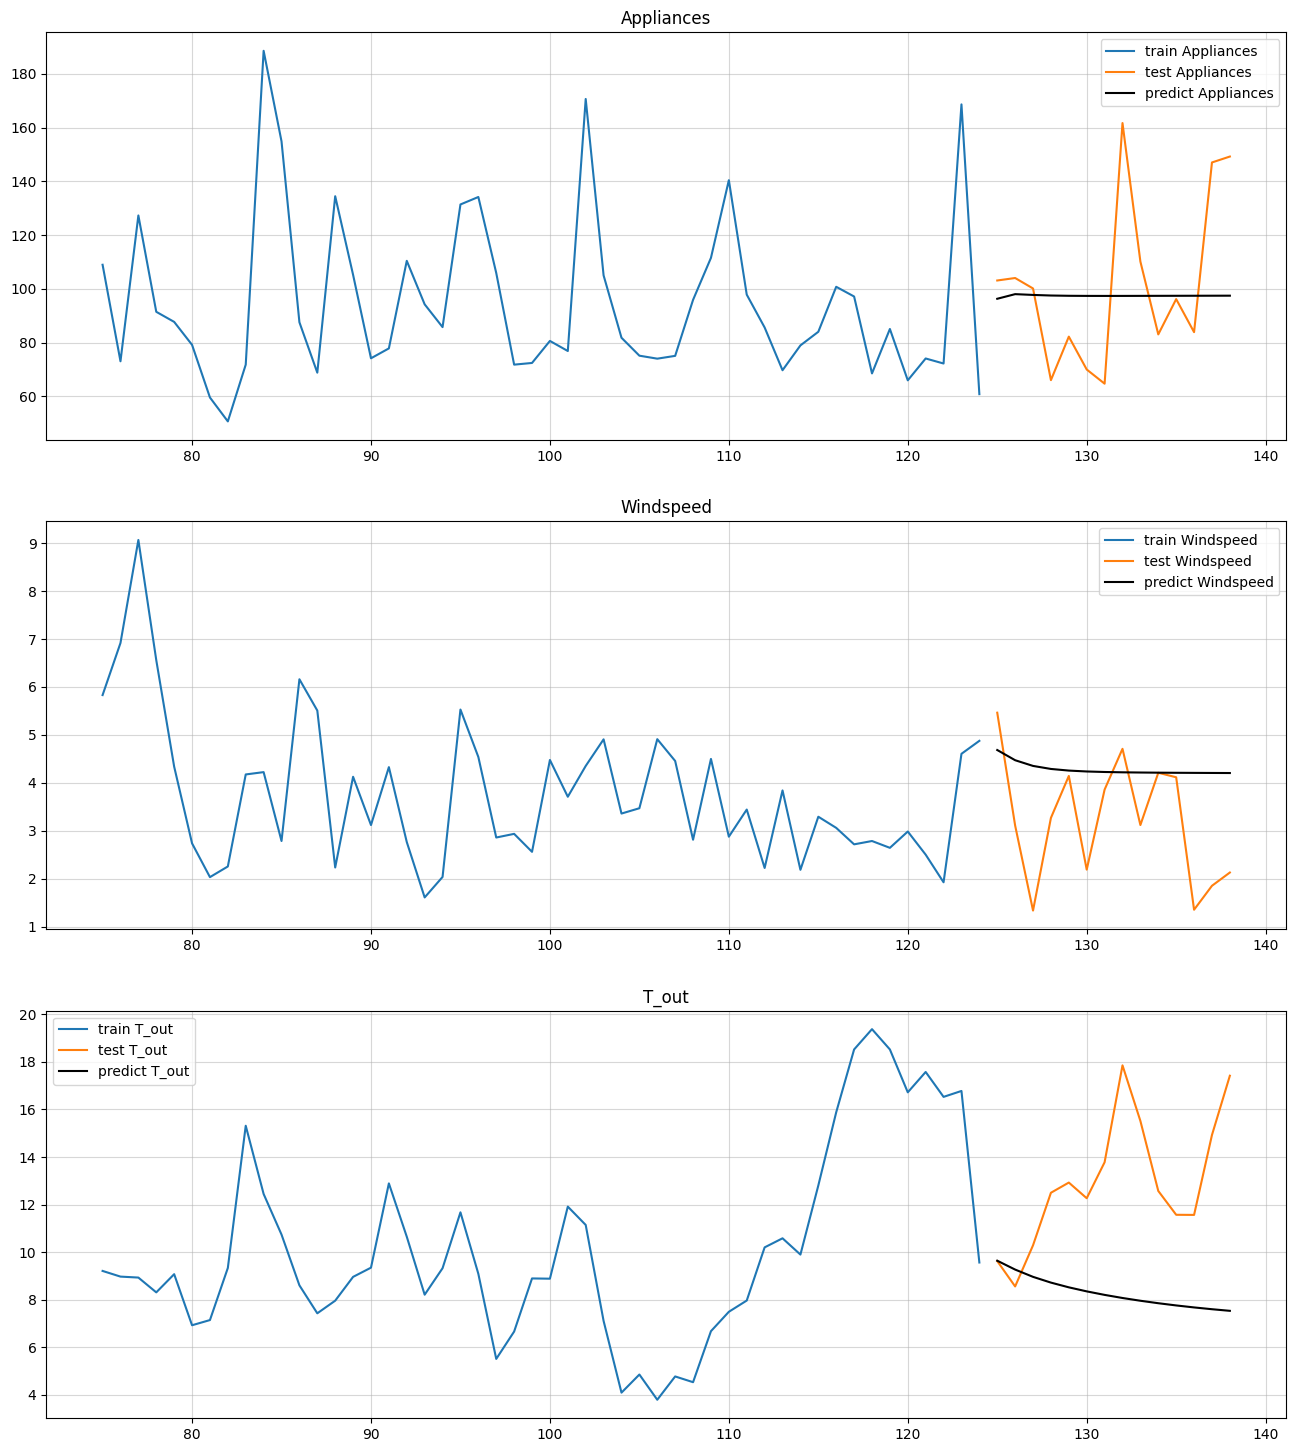

In [268]:
# visualising the predictions

temp1 = df_input2_train_roll.reset_index()
temp2 = df_input2_test_roll.reset_index()
temp2 = pd.DataFrame(temp2.values, columns = temp2.columns, index = range(temp1.shape[0],temp1.shape[0] + df_input2_test_roll.shape[0]))
temp3 = forecast2.set_index(temp2.index)

fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (16, 18))

# Appliances feature
ax[0].plot(temp1['Appliances'].tail(50), label = 'train Appliances')
ax[0].plot(temp2['Appliances'],label = 'test Appliances' )
ax[0].plot(temp3['Appliances'],label = 'predict Appliances', color = 'black')
ax[0].set_title('Appliances')
ax[0].grid(alpha=0.5, which = 'both')
ax[0].legend()

# Windspeed feature
ax[1].plot(temp1['Windspeed'].tail(50), label = 'train Windspeed')
ax[1].plot(temp2['Windspeed'],label = 'test Windspeed' )
ax[1].plot(temp3['Windspeed'],label = 'predict Windspeed', color = 'black')
ax[1].set_title('Windspeed')
ax[1].grid(alpha=0.5, which = 'both')
ax[1].legend()

# T_out feature
ax[2].plot(temp1['T_out'].tail(50), label = 'train T_out')
ax[2].plot(temp2['T_out'],label = 'test T_out' )
ax[2].plot(temp3['T_out'],label = 'predict T_out', color = 'black')
ax[2].set_title('T_out')
ax[2].grid(alpha=0.5, which = 'both')
ax[2].legend()

plt.show()

In [12]:
df_copy = df.copy()

In [355]:
df_copy.tail()

Appliances     lights      T_out  Press_mm_hg     RH_out  \
date                                                                            
2016-05-27 14:00:00  101.666667   1.666667  21.916667      755.800  59.000000   
2016-05-27 15:00:00   76.666667   0.000000  22.216667      755.675  57.333333   
2016-05-27 16:00:00  135.000000   0.000000  22.883333      755.375  55.000000   
2016-05-27 17:00:00  180.000000   3.333333  22.666667      755.200  55.833333   
2016-05-27 18:00:00  430.000000  10.000000  22.200000      755.200  57.000000   

                     Windspeed  Tdewpoint  Visibility  
date                                                   
2016-05-27 14:00:00   2.000000  13.475000   21.583333  
2016-05-27 15:00:00   2.000000  13.258333   21.833333  
2016-05-27 16:00:00   2.416667  13.283333   22.583333  
2016-05-27 17:00:00   3.416667  13.316667   24.083333  
2016-05-27 18:00:00   4.000000  13.200000   27.000000

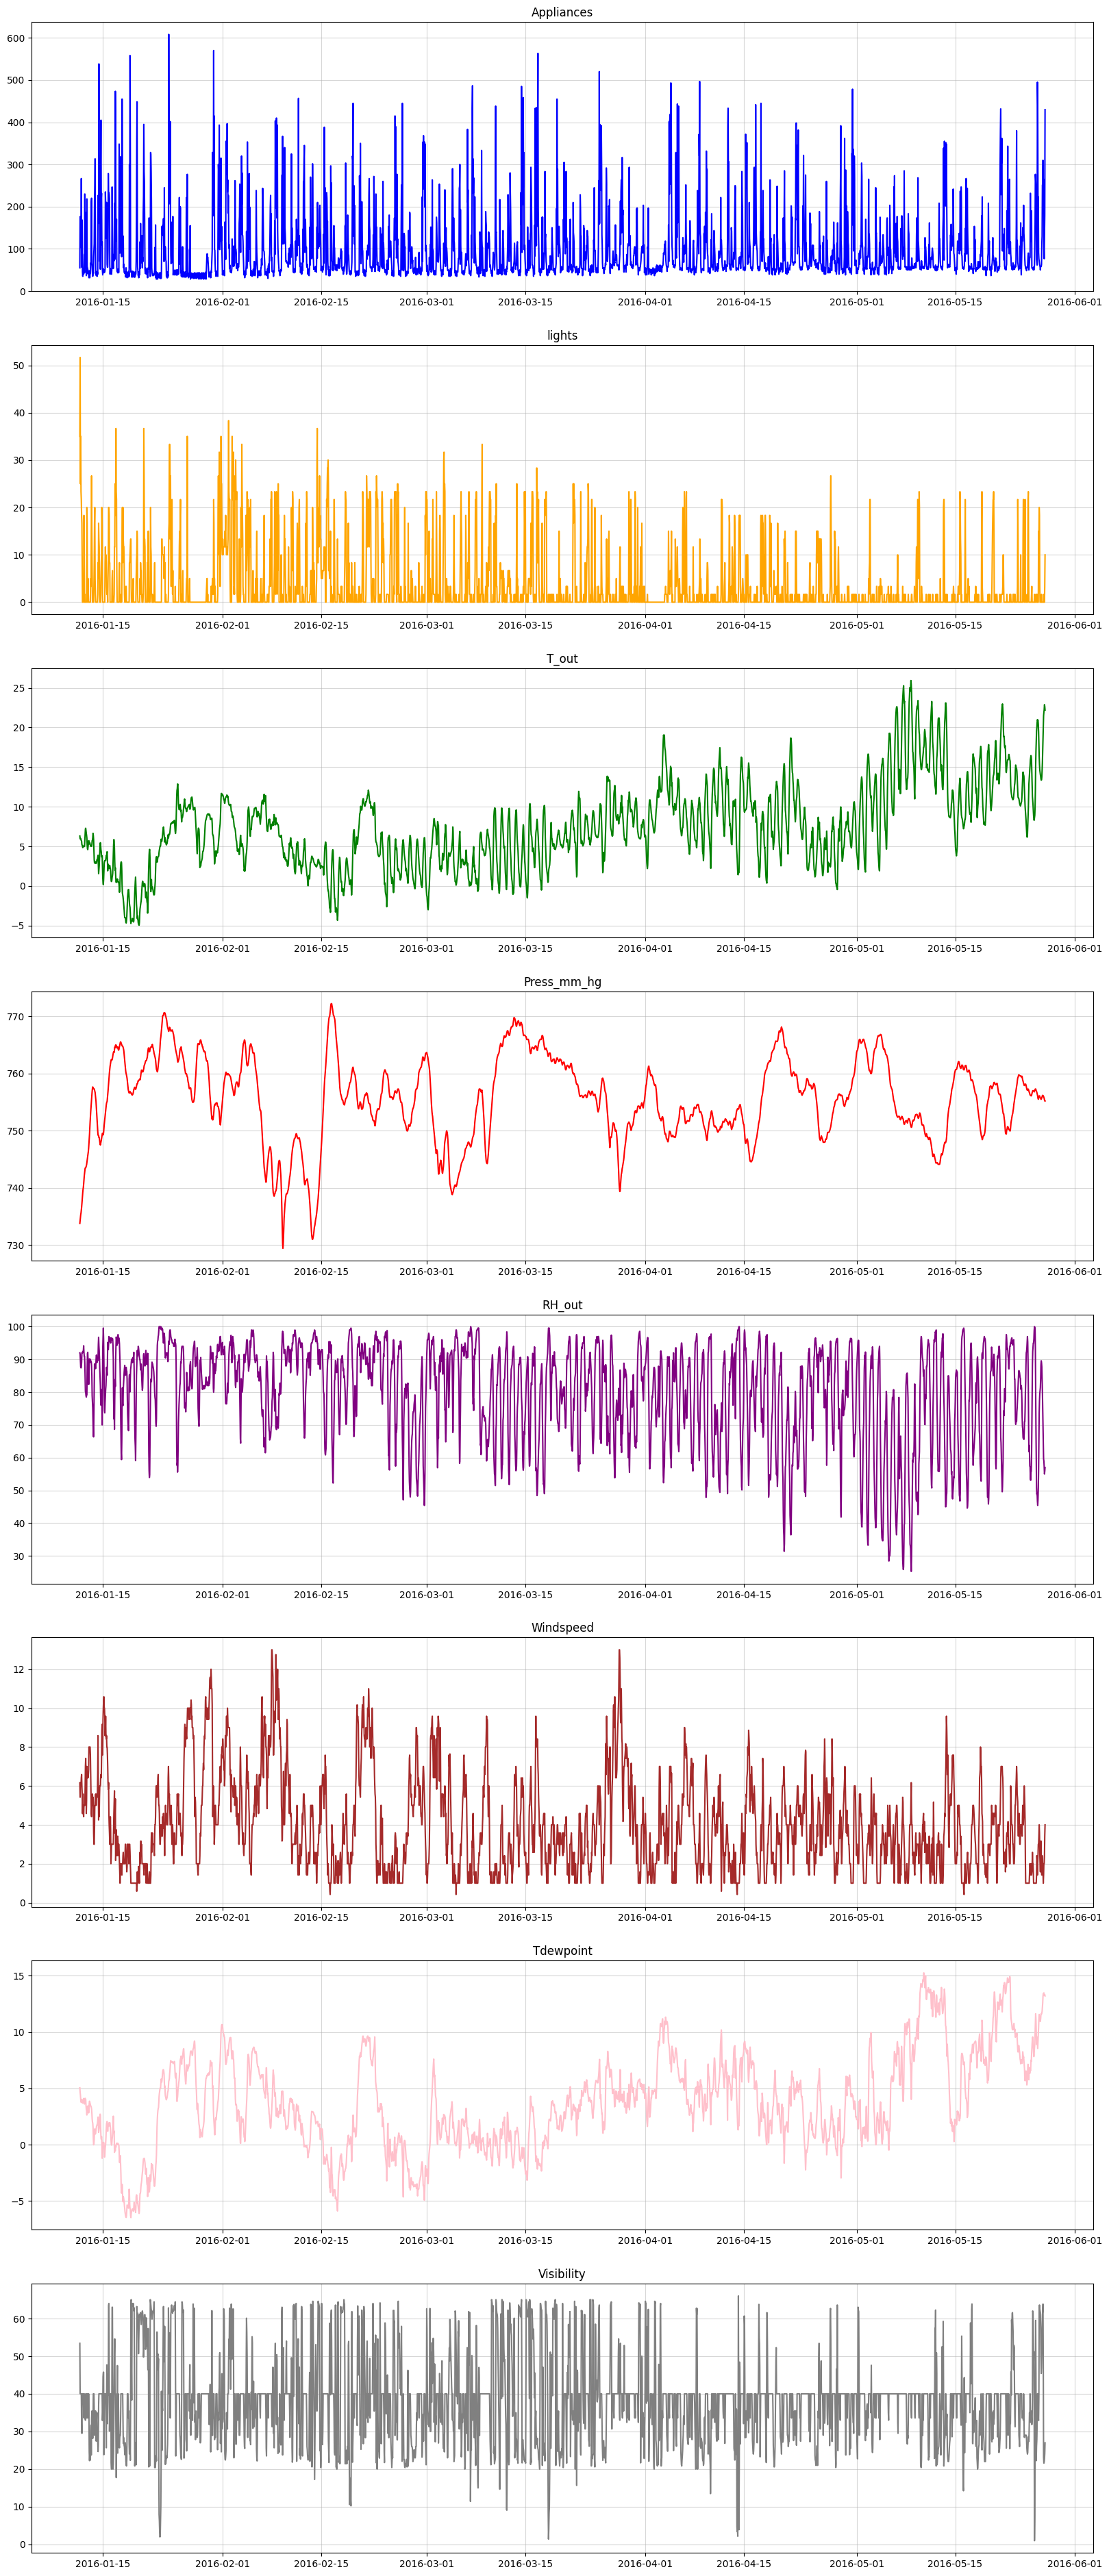

In [356]:
color_list = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

fig, ax = plt.subplots(nrows=8, ncols = 1, figsize = (20, 48))

for i in range(df_copy.shape[1]):
    ax[i].plot(df_copy.iloc[:,i], color = color_list[i])
    ax[i].grid(alpha = 0.5, which='both')
    ax[i].set_title(df.columns[i])

plt.show()

In [13]:
# convert the hourly data into daily data
df_copy = df_copy.resample('1D').mean()

In [358]:
df_copy.shape

(138, 8)

In [359]:
df_copy.tail()

Appliances    lights      T_out  Press_mm_hg     RH_out  \
date                                                                  
2016-05-23   83.055556  2.013889  12.570486   755.849653  84.225694   
2016-05-24   96.180556  4.236111  11.568750   759.007292  76.680556   
2016-05-25   83.888889  2.569444  11.563542   756.887500  74.774306   
2016-05-26  147.013889  3.125000  14.923611   756.619792  74.336806   
2016-05-27  149.210526  1.052632  17.414912   755.759211  73.517544   

            Windspeed  Tdewpoint  Visibility  
date                                          
2016-05-23   4.208333   9.851736   46.017361  
2016-05-24   4.114583   7.469097   33.975694  
2016-05-25   1.350694   6.819097   30.739583  
2016-05-26   1.850694   9.636458   39.329861  
2016-05-27   2.127193  12.288158   45.736842

In [17]:
def plot_df(df_copy) : 
    color_list = [
        "blue",
        "orange",
        "green",
        "red",
        "purple",
        "brown",
        "pink",
        "gray",
        "olive",
        "cyan",
    ]

    fig, ax = plt.subplots(nrows=8, ncols = 1, figsize = (20, 48))

    for i in range(df_copy.shape[1]):
        ax[i].plot(df_copy.iloc[:,i], color = color_list[i])
        ax[i].grid(alpha = 0.5, which='both')
        ax[i].set_title(df.columns[i])

    plt.show()

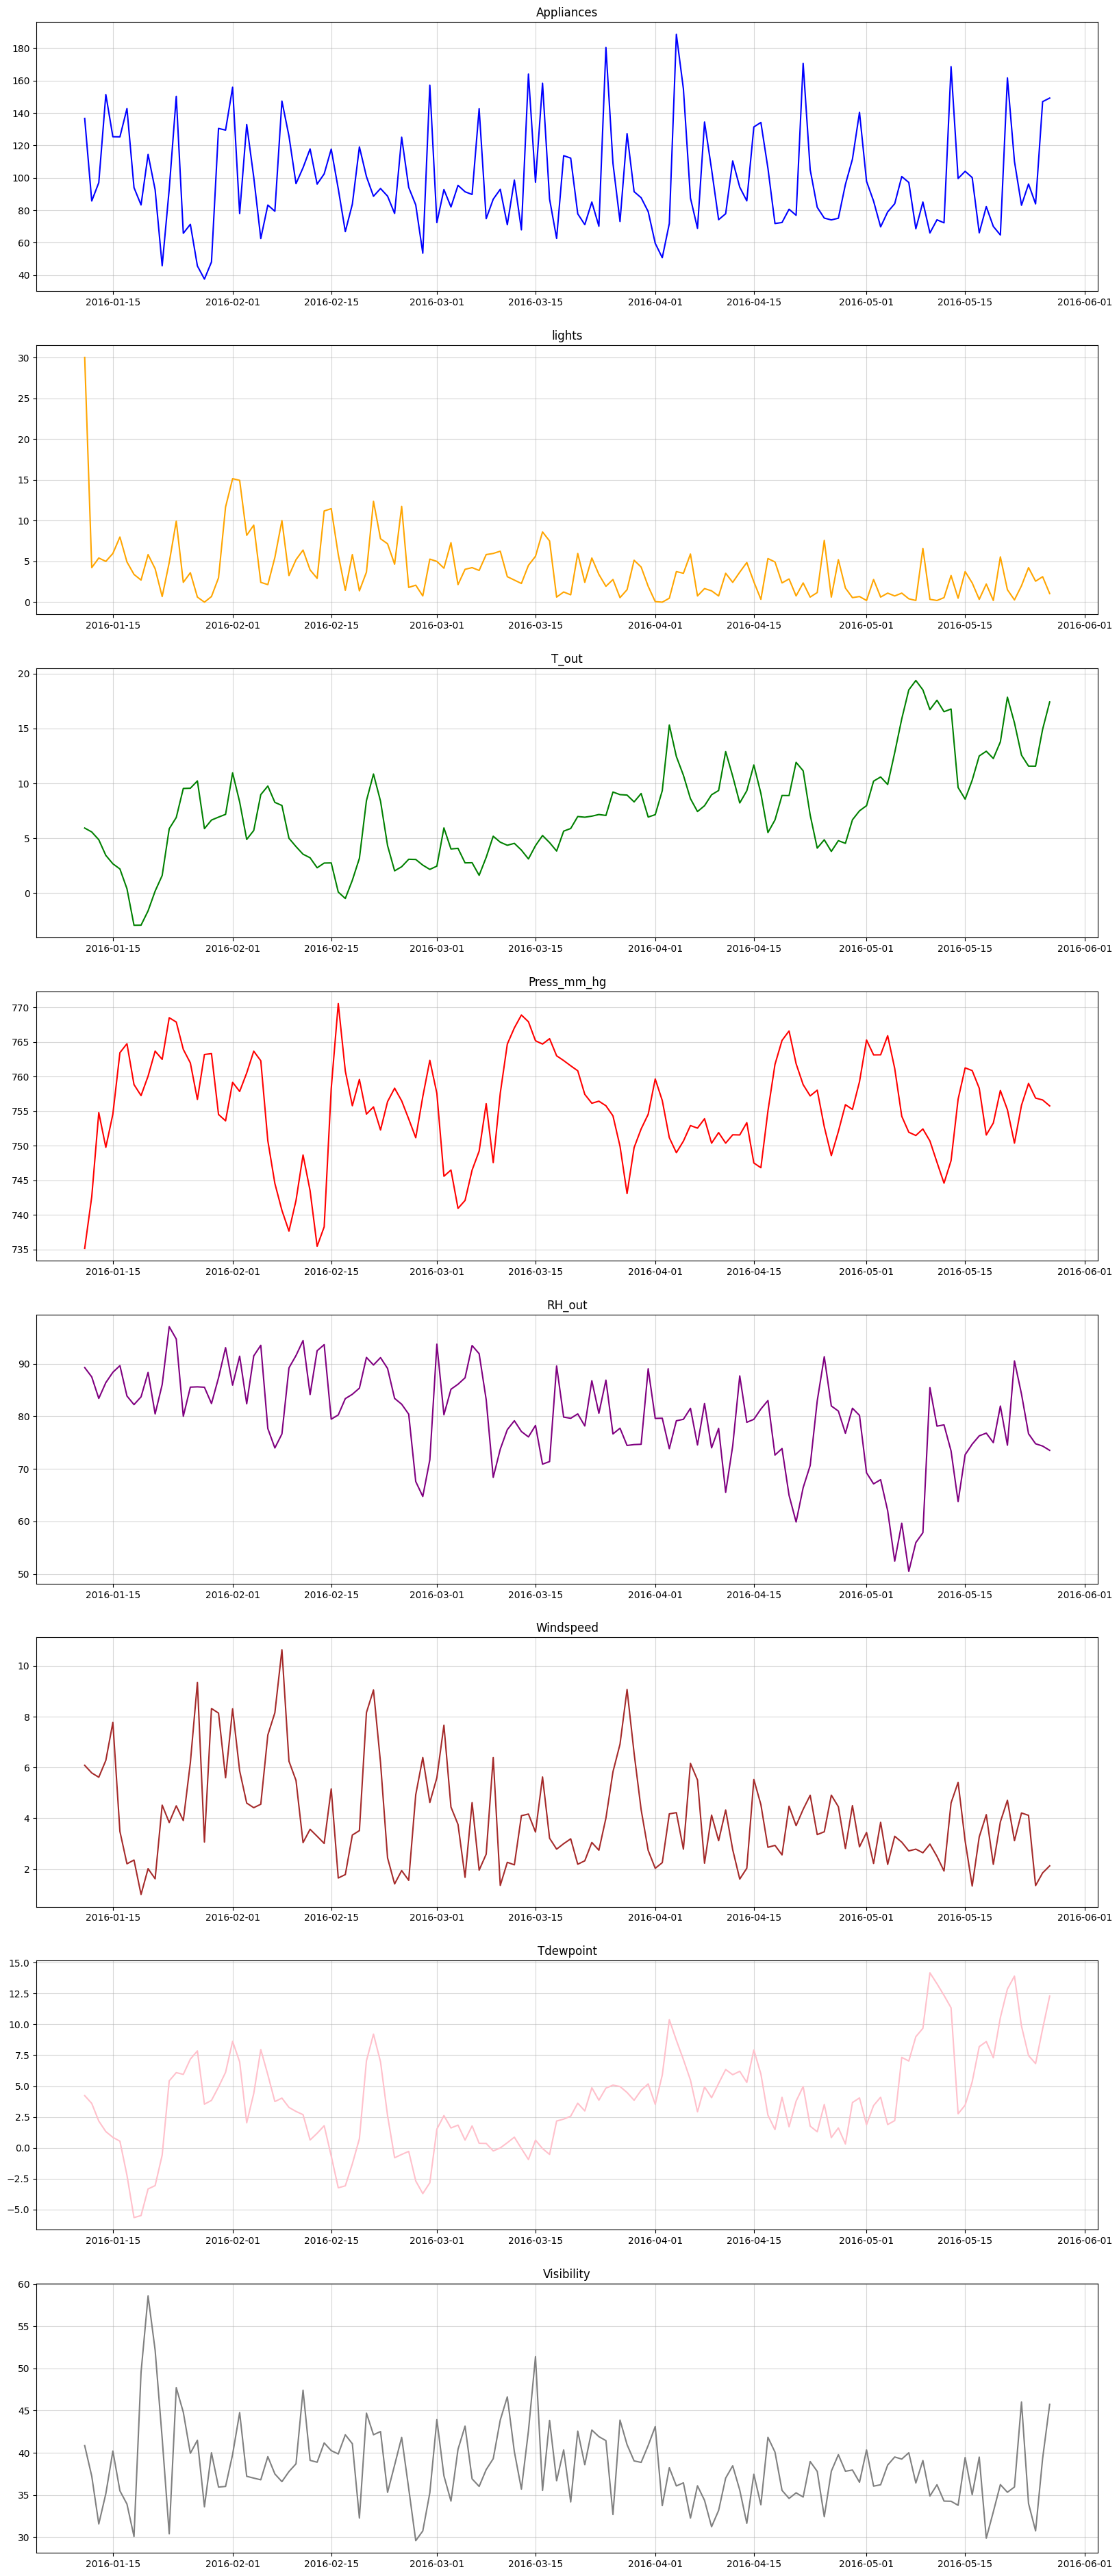

In [361]:
plot_df(df_copy)

In [14]:
# applyting log transformation
df_copy = np.log(df_copy)

c:\Users\RAJESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
c:\Users\RAJESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


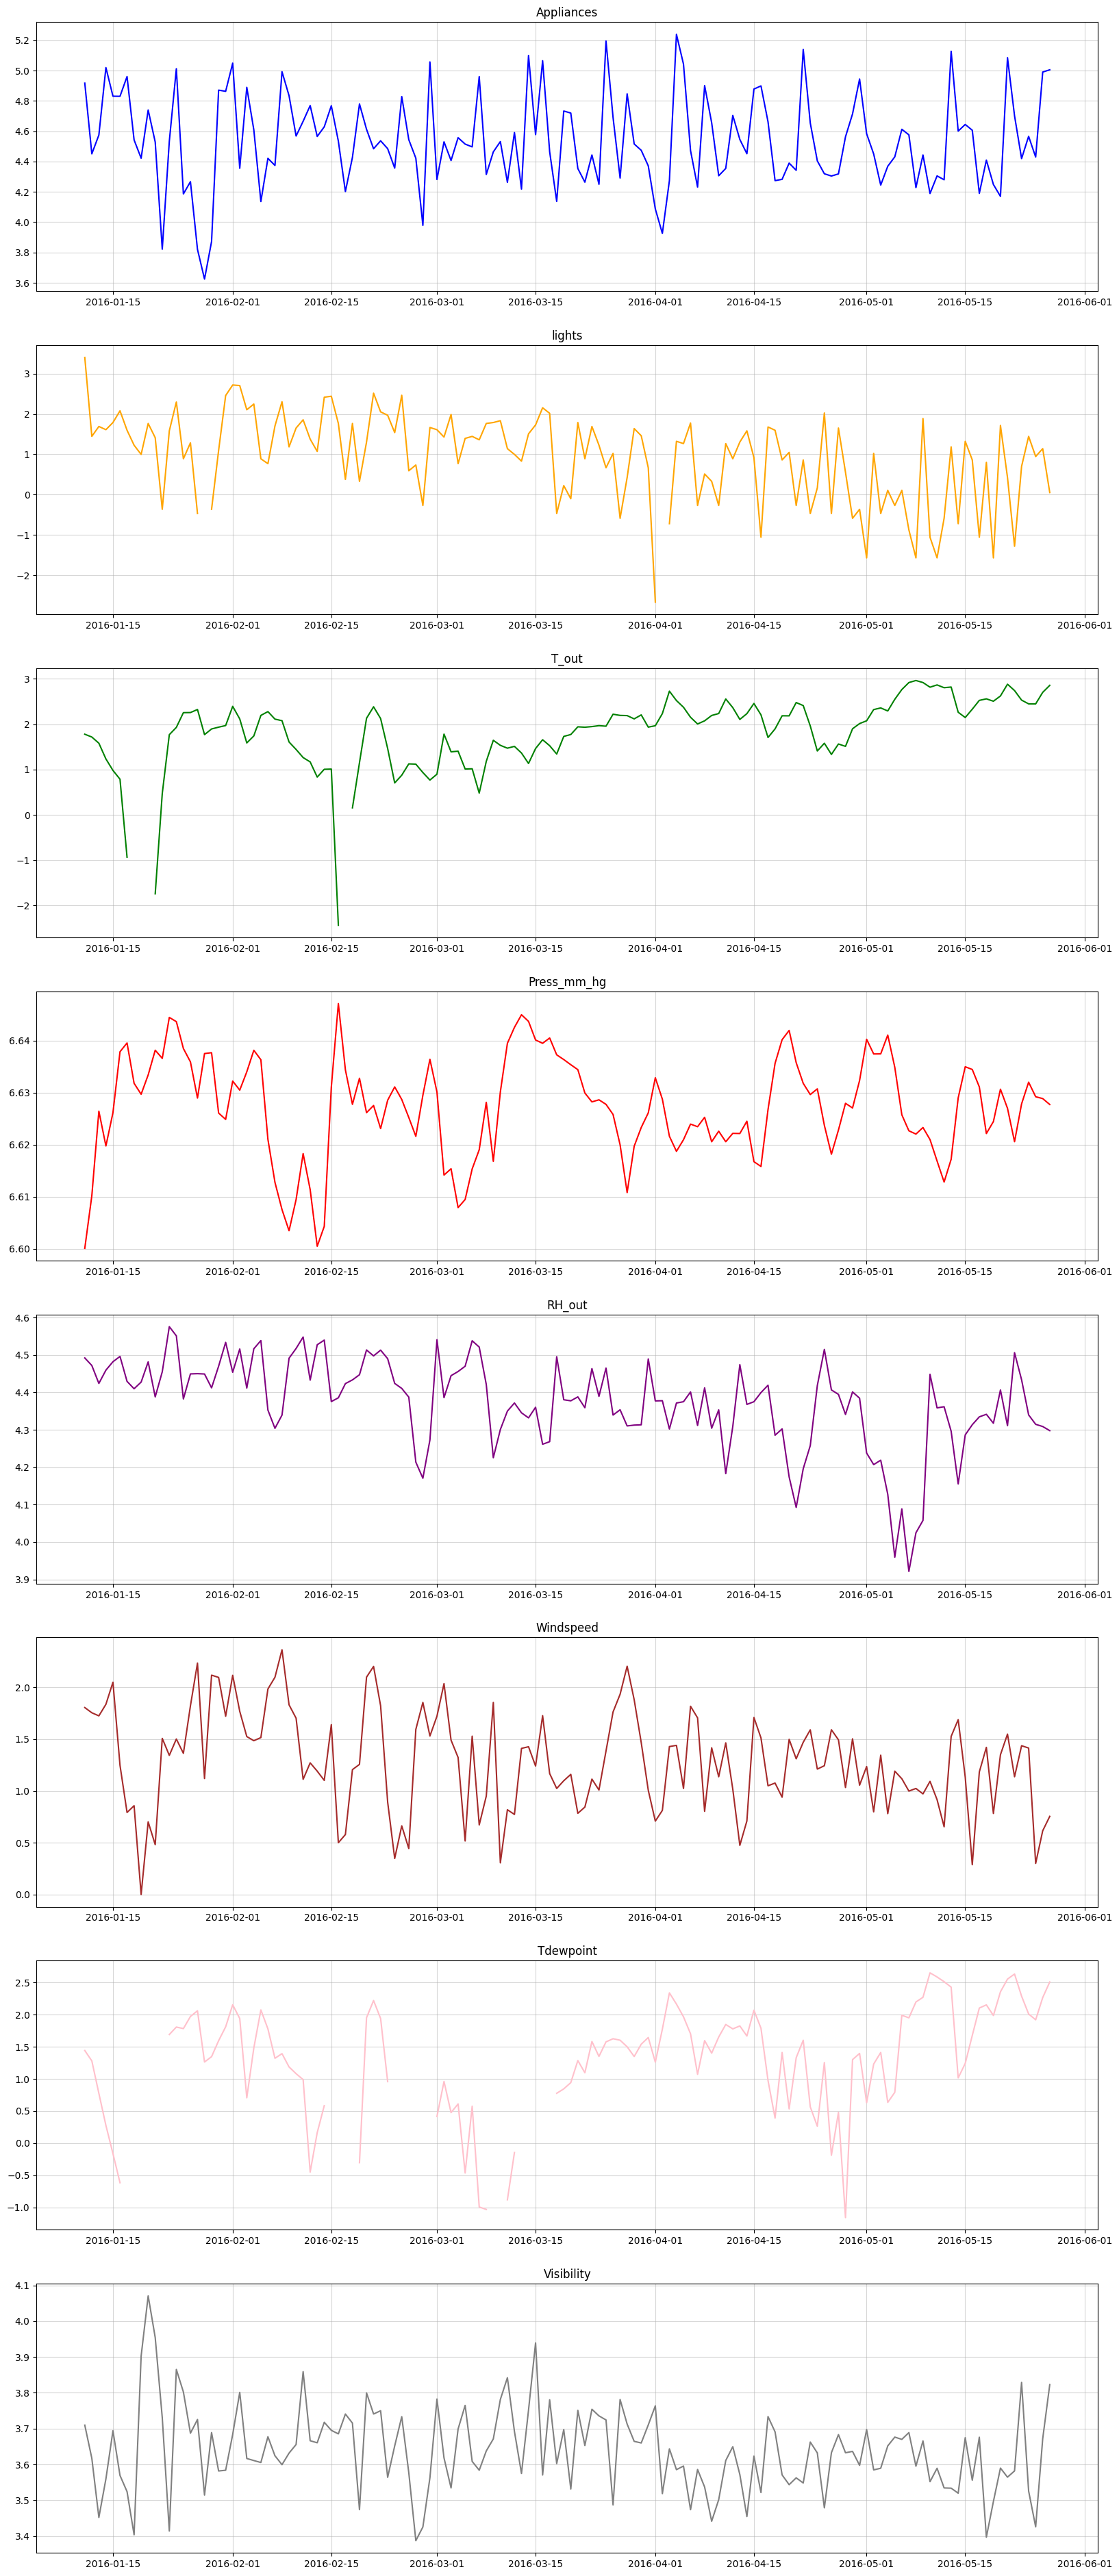

In [363]:
plot_df(df_copy)

In [15]:
# filling the missing values
df_copy = df_copy.ffill()

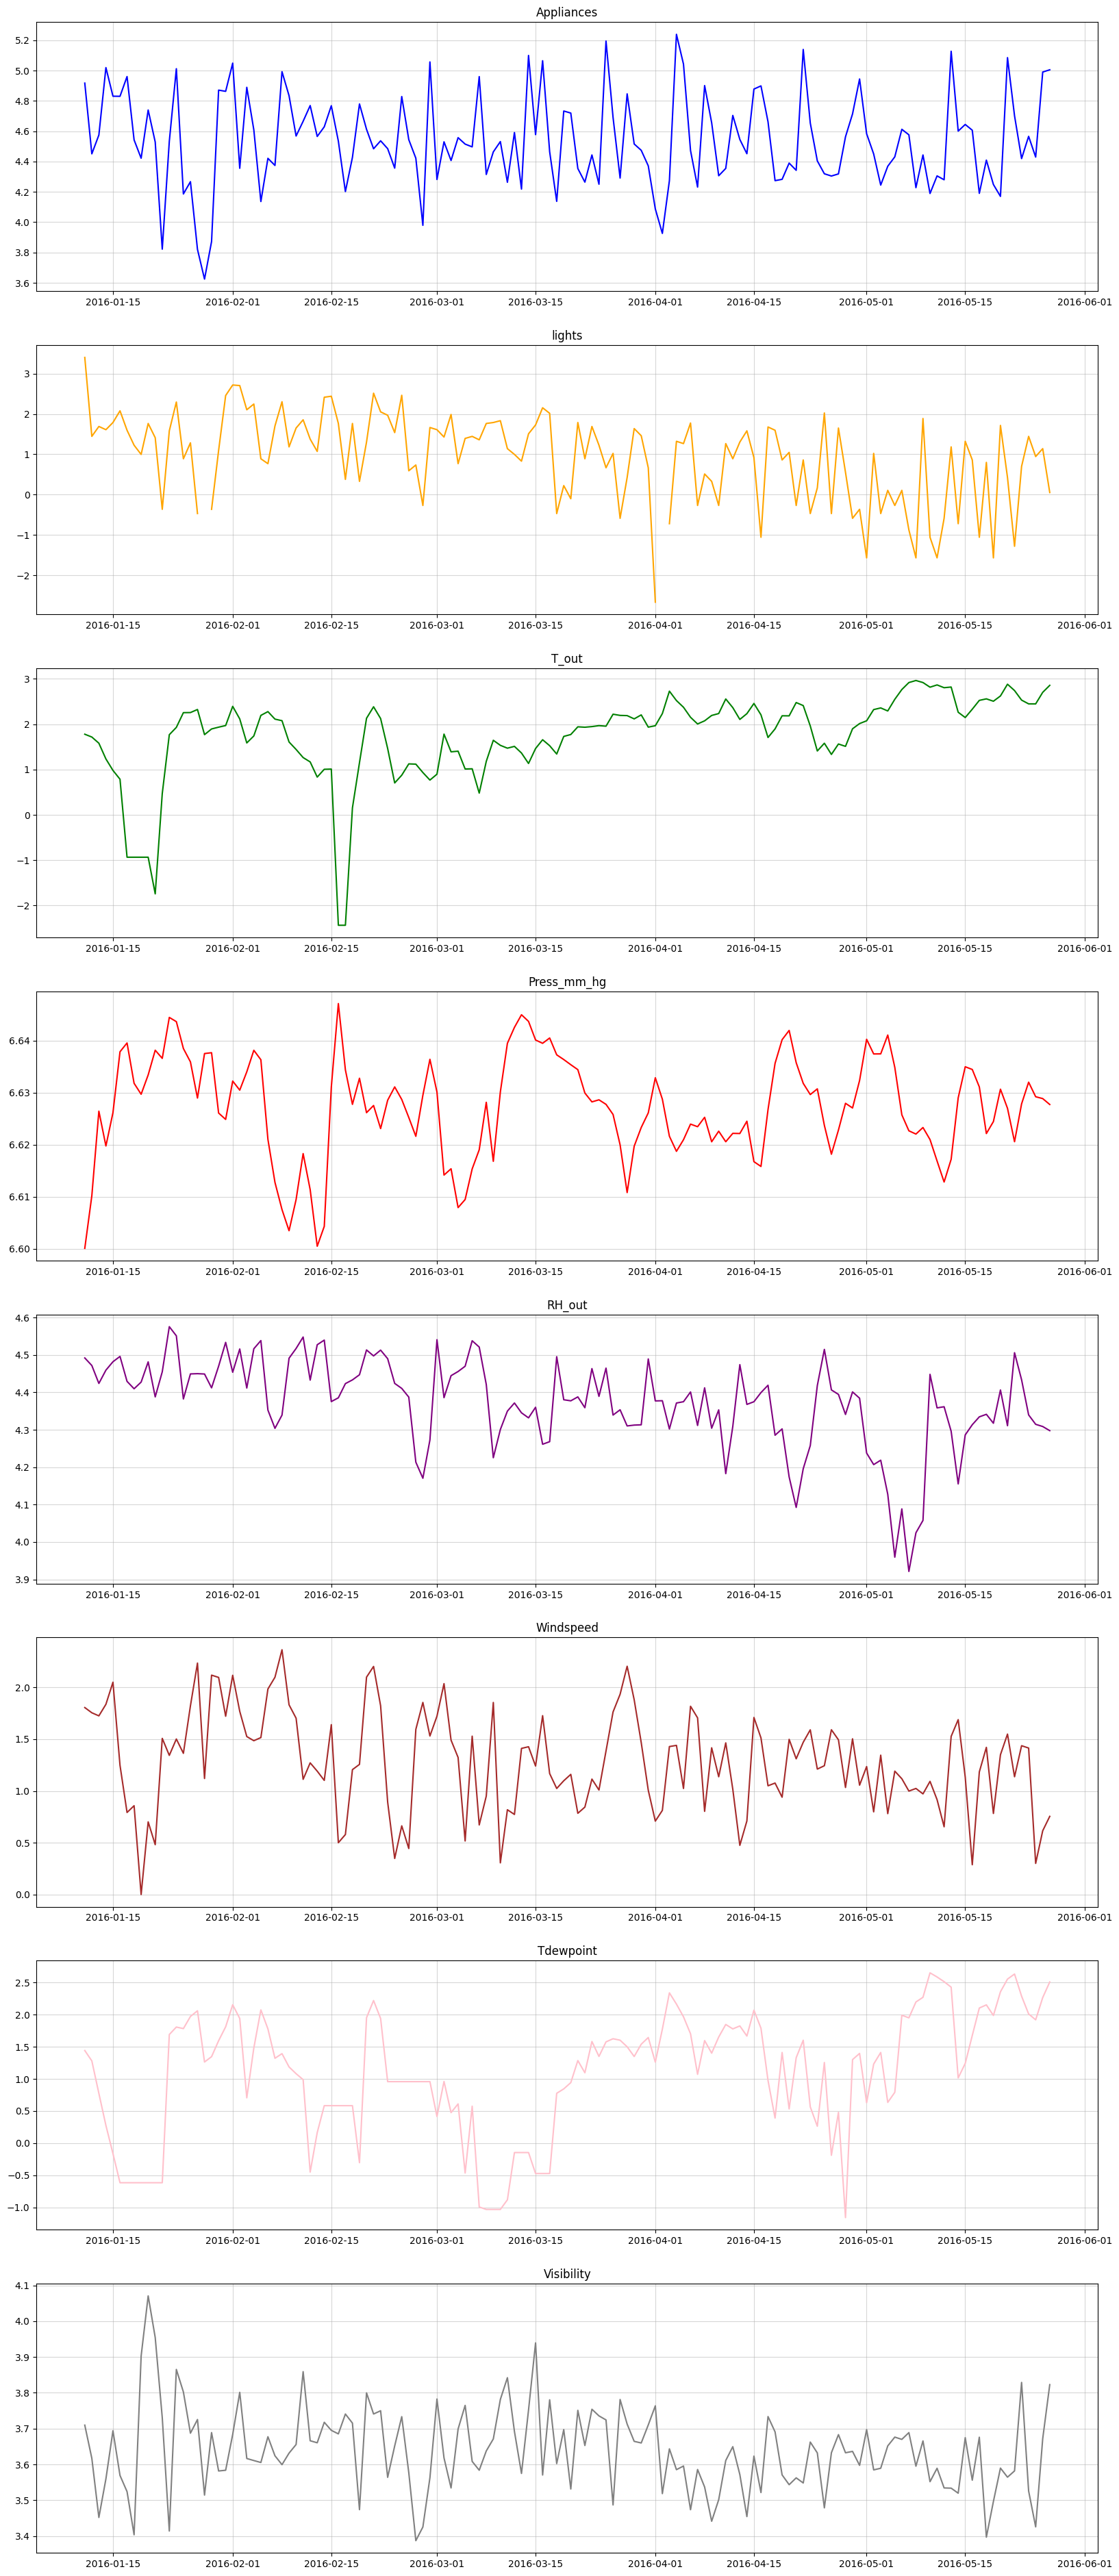

In [365]:
plot_df(df_copy)

In [16]:
df_copy = df_copy.diff().ffill()
plot_df(df_copy)

NameError: name 'plot_df' is not defined

In [18]:
# we will use all the features to train VARMAX model

# hangling infinite values
df_copy.replace({np.inf: 0.628839, -np.inf: 0.628839}, inplace=True)

# splitting 
df_copy_train = df_copy[:120]
df_copy_test = df_copy[120:]

In [370]:
df_copy_train.shape, df_copy_test.shape

((120, 8), (17, 8))

In [371]:

# training 
model = VARMAX(df_copy_train, freq = '1D')
result = model.fit()


c:\Users\RAJESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")
c:\Users\RAJESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [373]:
# forecasting
forecast = result.forecast(steps = df_copy_test.shape[0])

In [374]:
forecast.shape

(17, 8)

In [375]:
# visualising the predictions

temp1 = df_copy_train.reset_index()
temp2 = df_copy_test.reset_index()
temp2 = pd.DataFrame(temp2.values, columns = temp2.columns, index = range(temp1.shape[0],temp1.shape[0] + df_copy_test.shape[0]))
temp3 = forecast.set_index(temp2.index)


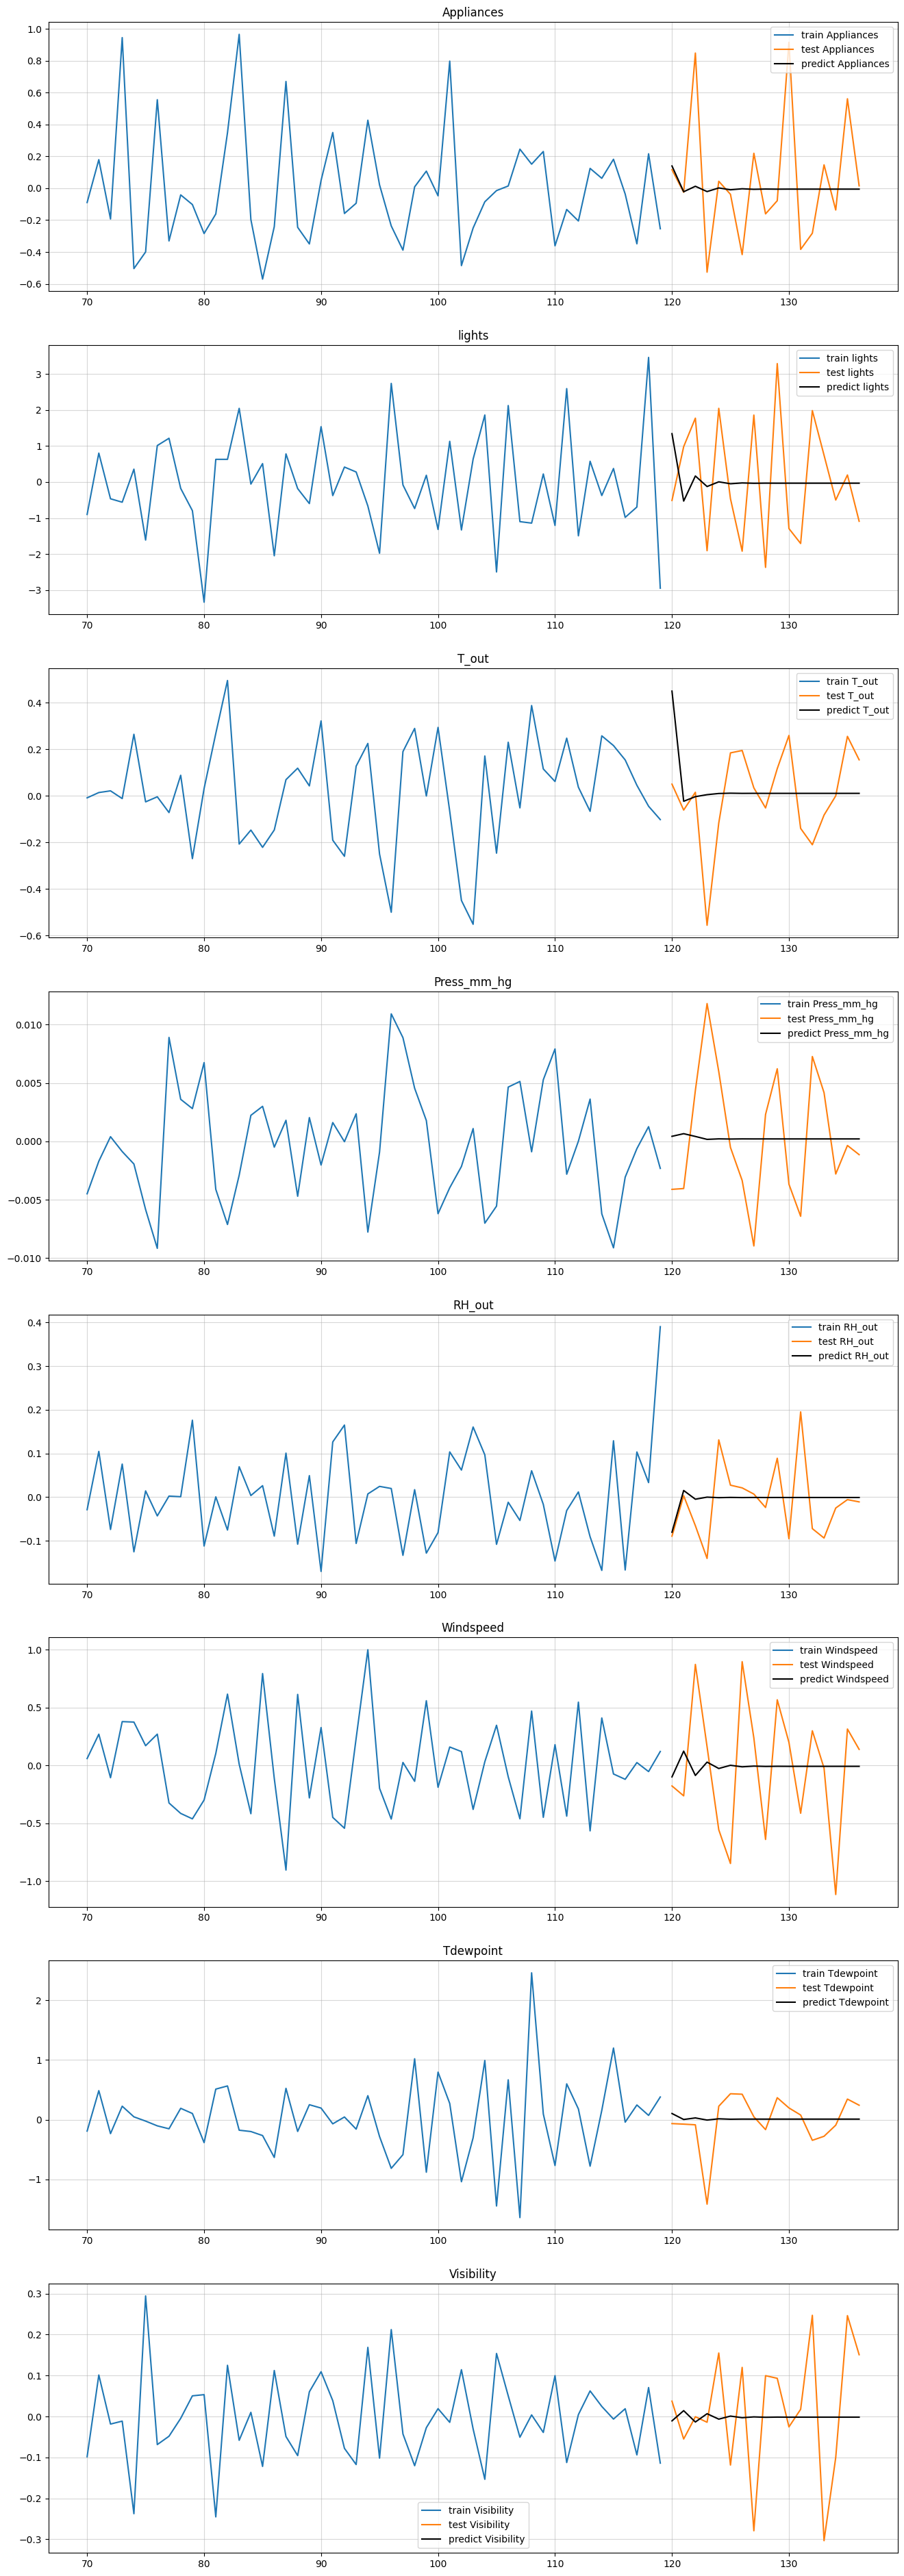

In [377]:

fig, ax = plt.subplots(nrows = 8, ncols = 1, figsize = (16, 48))

axis = 0
for i in df_copy.columns:
    ax[axis].plot(temp1[i].tail(50), label = f'train {i}')
    ax[axis].plot(temp2[i],label = f'test {i}' )
    ax[axis].plot(temp3[i],label = f'predict {i}', color = 'black')
    ax[axis].set_title(i)
    ax[axis].grid(alpha=0.5, which = 'both')
    ax[axis].legend()
    axis+=1

plt.show()

### prediction using SARIMAX model

In [21]:
# auto_arima() to get best values for p, d and q

df_copy_train.dropna(inplace = True)

for i in df_copy_train.columns:
    print(f'{i} column : \n')
    auto_arima(df_copy_train[i] ,test = 'adf',  start_p = 0, max_p = 10, start_q = 0, max_q= 10, start_d = 0, max_d = 10, trace = True, seasonal= True, stationary=True)
    print('\n')

C:\Users\RAJESH\AppData\Local\Temp\ipykernel_8152\1112224528.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy_train.dropna(inplace = True)


Appliances column : 

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=116.130, Time=0.44 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=104.746, Time=0.51 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=114.143, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=96.750, Time=0.30 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=91.388, Time=0.49 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=89.882, Time=1.36 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=85.092, Time=0.45 sec
 ARIMA(6,0,0)(0,0,0)[0] intercept   : AIC=78.089, Time=0.94 sec
 ARIMA(7,0,0)(0,0,0)[0] intercept   : AIC=80.016, Time=0.65 sec
 ARIMA(6,0,1)(0,0,0)[0] intercept   : AIC=69.332, Time=2.31 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.69 sec
 ARIMA(7,0,1)(0,0,0)[0] intercept   : AIC=70.499, Time=3.40 sec
 ARIMA(6,0,2)(0,0,0)[0] intercept   : AIC=70.334, Time=2.69 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=

In [24]:
pvalues = [6, 1, 1, 2, 3, 1, 0, 4]
dvalues = [0, 0, 0, 0, 0, 0, 0, 0]
qvalues = [1, 1, 2, 0, 1, 1, 1, 1]

models = []

# training SARIMAX model for all the features
for i in range(len(df_copy_train.columns)):
    sarimax = SARIMAX(df_copy_train[df_copy_train.columns[i]], order = (pvalues[i], dvalues[i], qvalues[i]),seasonal_order = (pvalues[i], dvalues[i], qvalues[i], 30))
    models.append(sarimax.fit())

c:\Users\RAJESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\RAJESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\RAJESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\RAJESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible st

In [26]:
df_copy_test.lights.shape

(18,)

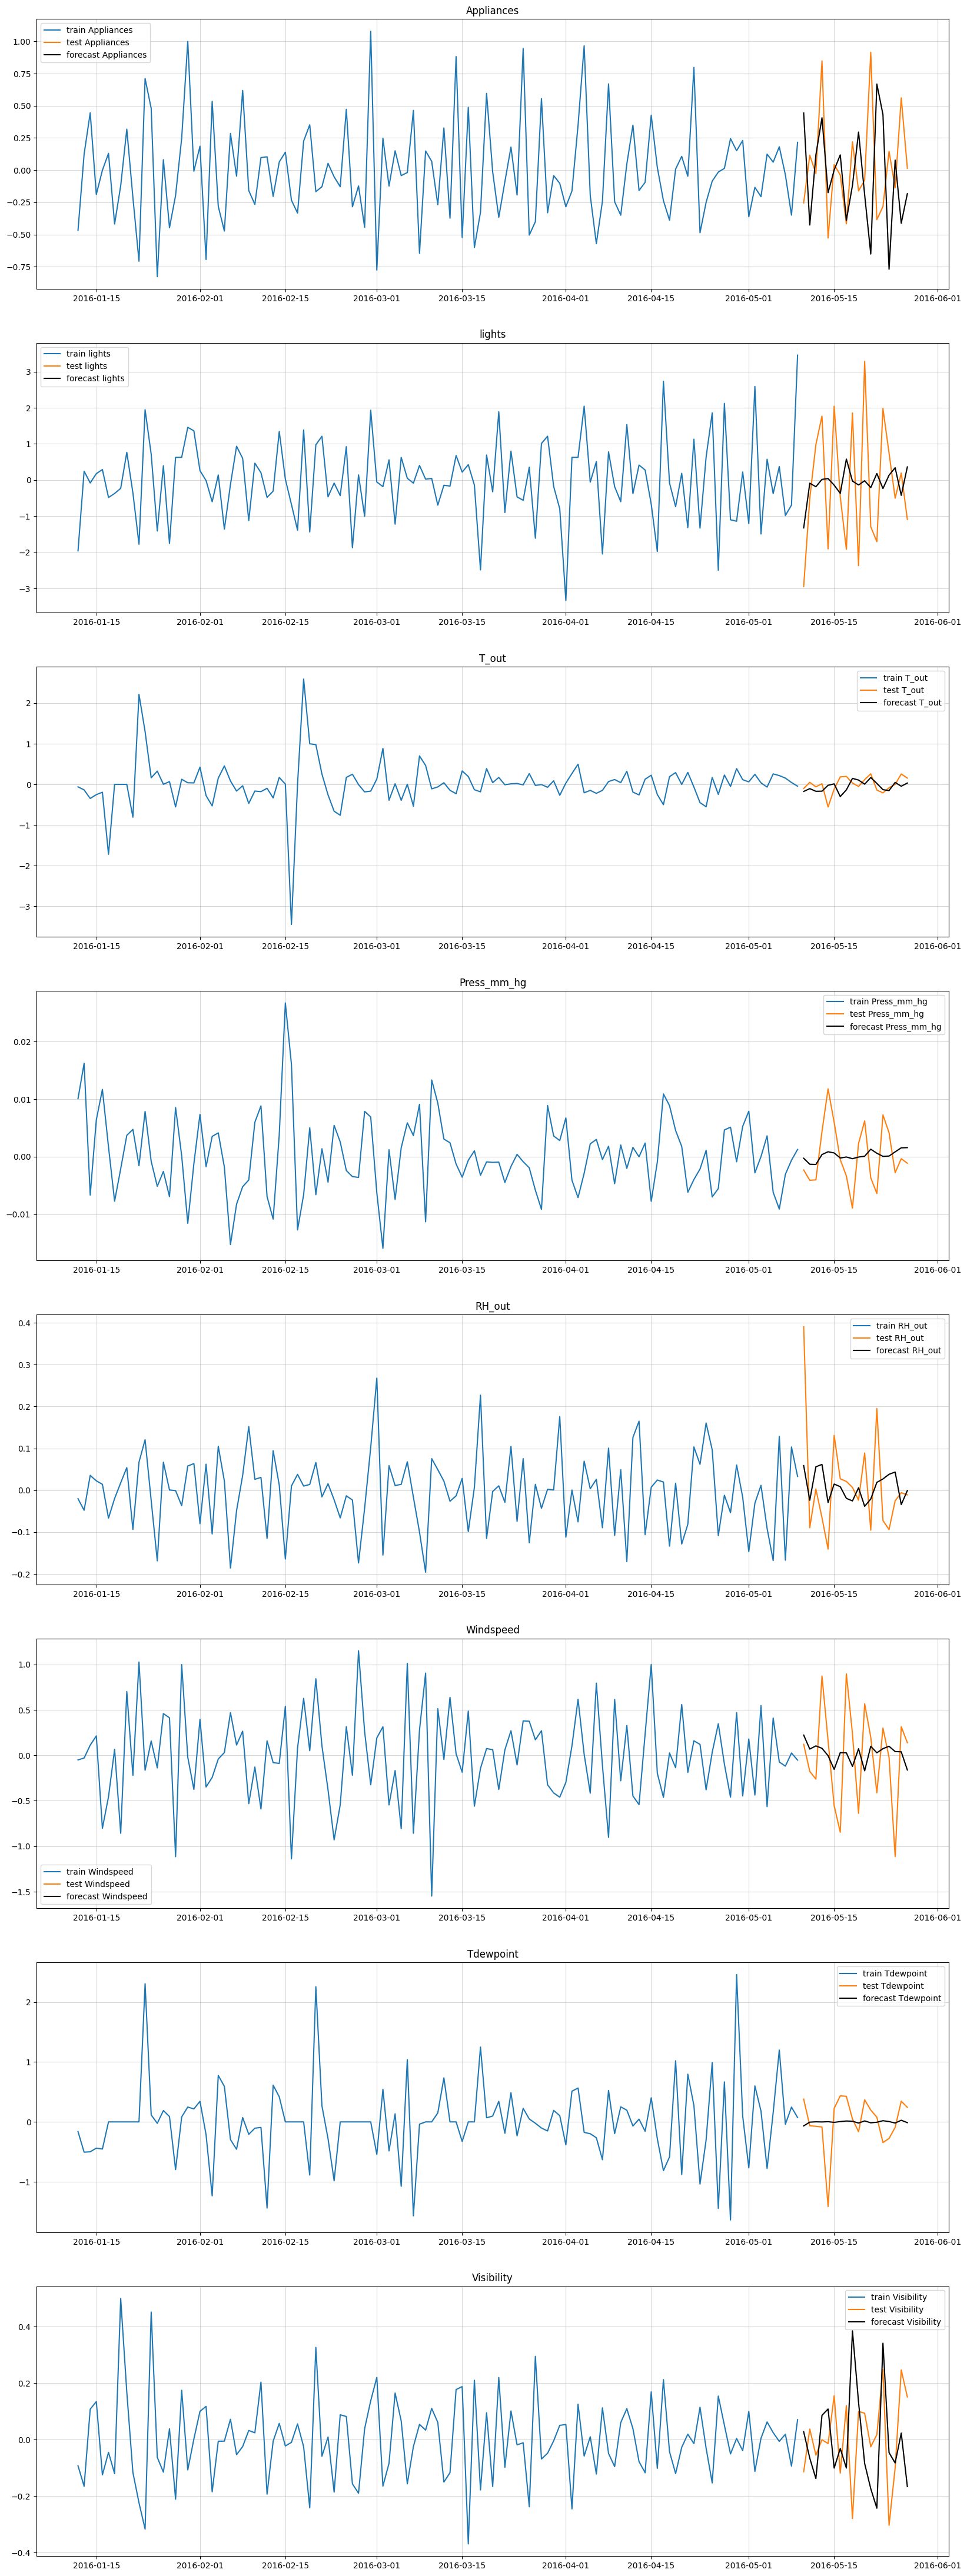

In [28]:
# forecasting and plotting for each feature

fig, ax = plt.subplots(nrows=len(df_copy.columns), ncols = 1, figsize = (20, 7*len(df_copy.columns)))

for i in range(len(models)):
    forecast = models[i].forecast(steps = df_copy_test[df_copy.columns[i]].shape[0])
    ax[i].plot(df_copy_train[df_copy.columns[i]], label = f'train {df_copy.columns[i]}')
    ax[i].plot(df_copy_test[df_copy.columns[i]], label = f'test {df_copy.columns[i]}')
    ax[i].plot(forecast, label = f'forecast {df_copy.columns[i]}', color = 'black')
    ax[i].set_title(f'{df_copy.columns[i]}')
    ax[i].legend()
    ax[i].grid(alpha = 0.5, which = 'both')

plt.show()


if we had more data points we could have got better results in both VARMAX() and SARIMAX()

#### we could also try prediction using sci-kit learn. for refrence see 'D:\python\ai\supervised learning\time series\timeseries_sklearn.ipynb'